# Genomic surveillance analysis in Germany

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

## Download data
### Map
With zip codes for geo matching

In [184]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

### Sequences
From RKI's Github

In [185]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   210  100   210    0     0    531      0 --:--:-- --:--:-- --:--:--   546
100 47.2M  100 47.2M    0     0  8129k      0  0:00:05  0:00:05 --:--:-- 9438k
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   216  100   216    0     0    488      0 --:--:-- --:--:-- --:--:--   505
100 18.2M  100 18.2M    0     0  9350k      0  0:00:02  0:00:02 --:--:-- 14.1M
+ bash scripts/

In [186]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [187]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [188]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [189]:
df.reason.value_counts()

N                             410143
X                             277896
A[B.1.1.7]                     35832
A[B.1.617.2]                   35749
Y                              28530
                               ...  
A[B1.1.529]                        0
A[KONTAKTMITENGL.MUTATION]         0
A[E484K/N501Y/P681R]               0
A[E484E/N501N/P681R]               0
A[E484E/N501N/P681P]               0
Name: reason, Length: 211, dtype: int64

In [190]:
import re

In [191]:
df

date reason  \
IMS_ID                                                                 
IMS-10294-CVDP-00001                               2021-01-14      X   
IMS-10294-CVDP-00325                               2020-11-08      X   
IMS-10294-CVDP-00326                               2020-11-08      X   
IMS-10294-CVDP-00327                               2020-11-08      X   
IMS-10294-CVDP-00329                               2020-11-09      X   
...                                                       ...    ...   
IMS-10722-CVDP-D6222480-3EDF-4FF5-AFD8-8E4DFF01... 2022-04-25      N   
IMS-10722-CVDP-19457521-80DA-4F9F-BEBE-DDC95FA3... 2022-04-25      N   
IMS-10722-CVDP-E3A5529E-9783-4780-9CEB-F98E4F59... 2022-04-25      N   
IMS-10722-CVDP-D7C153F4-179D-4D95-9270-3AD6B76C... 2022-04-25      N   
IMS-10722-CVDP-EBE23DA9-F8D9-4CE0-AE5E-5B8E07CB... 2022-04-25      N   

                                                   processing_date sending_pc  \
IMS_ID                                                                          
IMS-10294-CVDP-00001                                    2021-01-25      40225   
IMS-10294-CVDP-00325                                    2021-02-14      40225   
IMS-10294-CVDP-00326                                    2021-02-14      40225   
IMS-10294-CVDP-00327                                    2021-02-14      40225   
IMS-10294-CVDP-00329                                    2021-02-14      40225   
...                                                            ...        ...   
IMS-10722-CVDP-D6222480-3EDF-4FF5-AFD8-8E4DFF01...      2022-04-29      80331   
IMS-10722-CVDP-19457521-80DA-4F9F-BEBE-DDC95FA3...      2022-04-29      80331   
IMS-10722-CVDP-E3A5529E-9783-4780-9CEB-F98E4F59...      2022-04-29      80331   
IMS-10722-CVDP-D7C153F4-179D-4D95-9270-3AD6B76C...      2022-04-29      80331   
IMS-10722-CVDP-EBE23DA9-F8D9-4CE0-AE5E-5B8E07CB...      2022-04-29      80331   

                                                   sequencing_pc    lineage  \
IMS_ID                                                                        
IMS-10294-CVDP-00001                                       40225  B.1.1.297   
IMS-10294-CVDP-00325                                       40225    B.1.221   
IMS-10294-CVDP-00326                                       40225    B.1.160   
IMS-10294-CVDP-00327                                       40225    B.1.258   
IMS-10294-CVDP-00329                                       40225  B.1.1.521   
...                                                          ...        ...   
IMS-10722-CVDP-D6222480-3EDF-4FF5-AFD8-8E4DFF01...         80331       BA.2   
IMS-10722-CVDP-19457521-80DA-4F9F-BEBE-DDC95FA3...         80331       BA.2   
IMS-10722-CVDP-E3A5529E-9783-4780-9CEB-F98E4F59...         80331     BA.2.9   
IMS-10722-CVDP-D7C153F4-179D-4D95-9270-3AD6B76C...         80331       BA.2   
IMS-10722-CVDP-EBE23DA9-F8D9-4CE0-AE5E-5B8E07CB...         80331     BA.2.9   

                                                                scorpio  \
IMS_ID                                                                    
IMS-10294-CVDP-00001                                                NaN   
IMS-10294-CVDP-00325                                                NaN   
IMS-10294-CVDP-00326                                                NaN   
IMS-10294-CVDP-00327                                                NaN   
IMS-10294-CVDP-00329                                                NaN   
...                                                                 ...   
IMS-10722-CVDP-D6222480-3EDF-4FF5-AFD8-8E4DFF01...  Omicron (BA.2-like)   
IMS-10722-CVDP-19457521-80DA-4F9F-BEBE-DDC95FA3...  Omicron (BA.2-like)   
IMS-10722-CVDP-E3A5529E-9783-4780-9CEB-F98E4F59...  Omicron (BA.2-like)   
IMS-10722-CVDP-D7C153F4-179D-4D95-9270-3AD6B76C...  Omicron (BA.2-like)   
IMS-10722-CVDP-EBE23DA9-F8D9-4CE0-AE5E-5B8E07CB...  Omicron (BA.2-like)   

                                                             b

In [192]:
df.lineage[df.date > np.datetime64("today") - np.timedelta64(30, "D")].cat.remove_unused_categories().value_counts()

BA.2          29183
BA.2.9         7553
BA.1.1          956
BA.2.3          855
BA.2.5          269
BA.2.10         214
BA.1.1.1        196
BA.2.1          177
BA.2.12         149
BA.1             74
Unassigned       69
BA.5             61
BA.1.18          61
BA.2.10.1        47
BA.2.7           38
BA.3             35
BA.1.17.2        34
BA.2.13          30
BA.1.1.14        30
BA.2.14          25
BA.2.8           24
BA.2.11          21
BA.2.3.2         19
BA.2.6           19
BA.2.12.1        18
BA.1.17          11
B.1.1.10         10
BA.4              9
BA.1.15           8
BA.1.1.15         6
AY.98.1           6
BA.2.4            5
XE                5
BA.1.1.13         4
XM                4
BA.1.21           3
B.1.1.529         2
BA.1.1.11         2
BA.2.9.1          1
BA.1.16           1
BA.1.13           1
BA.1.12           1
BA.1.1.10         1
BA.1.1.4          1
B.1.1             1
Name: lineage, dtype: int64

In [193]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.add_categories(['Other'])
l = df.lineage.cat.remove_unused_categories()

In [194]:
ba = [x for x in l.cat.categories if x.startswith('BA') ]
ba

['BA.1',
 'BA.1.1',
 'BA.1.1.1',
 'BA.1.13',
 'BA.1.13.1',
 'BA.1.14.1',
 'BA.1.15',
 'BA.1.17',
 'BA.1.17.2',
 'BA.1.18',
 'BA.1.19',
 'BA.1.21',
 'BA.1.9',
 'BA.1.1.10',
 'BA.1.1.11',
 'BA.1.1.13',
 'BA.1.1.14',
 'BA.1.1.15',
 'BA.1.1.16',
 'BA.1.1.2',
 'BA.1.1.3',
 'BA.1.1.9',
 'BA.1.10',
 'BA.1.12',
 'BA.1.14',
 'BA.1.15.1',
 'BA.1.16',
 'BA.1.20',
 'BA.1.21.1',
 'BA.1.4',
 'BA.1.5',
 'BA.1.8',
 'BA.2',
 'BA.2.11',
 'BA.2.9',
 'BA.3',
 'BA.1.1.12',
 'BA.1.1.17',
 'BA.1.1.4',
 'BA.1.1.6',
 'BA.1.1.7',
 'BA.1.1.8',
 'BA.1.14.2',
 'BA.1.15.2',
 'BA.1.16.2',
 'BA.1.2',
 'BA.1.6',
 'BA.1.7',
 'BA.2.1',
 'BA.2.10',
 'BA.2.10.1',
 'BA.2.12',
 'BA.2.3',
 'BA.2.4',
 'BA.2.5',
 'BA.2.7',
 'BA.1.17.1',
 'BA.1.1.5',
 'BA.2.14',
 'BA.2.3.2',
 'BA.2.8',
 'BA.2.13',
 'BA.2.15',
 'BA.2.16',
 'BA.2.2',
 'BA.2.6',
 'BA.2.9.1',
 'BA.1.16.1',
 'BA.2.12.1',
 'BA.4',
 'BA.5']

In [195]:
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2'] + ba),"lineage"] = "Other"
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage.cat.remove_unused_categories(), dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[(i + 1) % genomes.shape[1] for i in range(genomes.shape[1])]]
genomes

lineage                       BA.1  BA.1.1  BA.1.1.1  BA.1.13  BA.1.13.1  \
bundesland        date                                                     
Baden-Württemberg 2021-11-01     0       0         0        0          0   
                  2021-11-02     0       0         0        0          0   
                  2021-11-03     0       0         0        0          0   
                  2021-11-04     0       0         0        0          0   
                  2021-11-05     0       0         0        0          0   
...                            ...     ...       ...      ...        ...   
Thüringen         2022-04-22     0       0         0        0          0   
                  2022-04-23     0       0         0        0          0   
                  2022-04-24     0       0         0        0          0   
                  2022-04-25     0       0         0        0          0   
                  2022-04-26     0       0         0        0          0   

lineage                       BA.1.14.1  BA.1.15  BA.1.17  BA.1.17.2  BA.1.18  \
bundesland        date                                                          
Baden-Württemberg 2021-11-01          0        0        0          0        0   
                  2021-11-02          0        0        0          0        0   
                  2021-11-03          0        0        0          0        0   
                  2021-11-04          0        0        0          0        0   
                  2021-11-05          0        0        0          0        0   
...                                 ...      ...      ...        ...      ...   
Thüringen         2022-04-22          0        0        0          0        0   
                  2022-04-23          0        0        0          0        0   
                  2022-04-24          0        0        0          0        0   
                  2022-04-25          0        0        0          0        0   
                  2022-04-26          0        0        0          0        0   

lineage                       ...  BA.2.16  BA.2.2  BA.2.6  BA.2.9.1  \
bundesland        date        ...                                      
Baden-Württemberg 2021-11-01  ...        0       0       0         0   
                  2021-11-02  ...        0       0       0         0   
                  2021-11-03  ...        0       0       0         0   
                  2021-11-04  ...        0       0       0         0   
                  2021-11-05  ...        0       0       0         0   
...                           ...      ...     ...     ...       ...   
Thüringen         2022-04-22  ...        0       0       0         0   
                  2022-04-23  ...        0       0       0         0   
                  2022-04-24  ...        0       0       0         0   
                  2022-04-25  ...        0       0       0         0   
                  2022-04-26  ...        0       0       0         0   

lineage                       BA.1.16.1  BA.2.12.1  BA.4  BA.5  Other  \
bundesland        date                                                  
Baden-Württemberg 2021-11-01          0          0     0     0      0   
                  2021-11-02          0          0     0     0      0   
                  2021-11-03          0          0     0     0      0   
                  2021-11-04          0          0     0     0      0   
                  2021-11-05          0          0     0     0      0   
...                                 ...        ...   ...   ...    ...   
Thüringen         2022-04-22          0          0     0     0      0   
                  2022-04-23          0          0     0     0      0   
                  2022-04-24          0          0     0     0      0   
                  2022-04-25          0          0     0     0      0   
                  2022-04-26          0          0     0     0      0   

lineage                       B.1.617.2  
bundesland        date      

In [196]:
genomes.sum(level=0)

lineage                 BA.1  BA.1.1  BA.1.1.1  BA.1.13  BA.1.13.1  BA.1.14.1  \
bundesland                                                                      
Baden-Württemberg       4941   23584      3854       59          2         19   
Bayern                  1051    6023       831       27          0          2   
Berlin                   183     759       194       26          0          0   
Brandenburg              309    1310       309       22          5          0   
Bremen                    59     510        34        5          0          0   
Hamburg                 1198    3697       288        9          0          1   
Hessen                   395    1572       197        7          0          0   
Mecklenburg-Vorpommern   258     859       122        4          5          0   
Niedersachsen            333    1314       206        4          0          0   
Nordrhein-Westfalen     6265   25031      4700       70         28          7   
Rheinland-Pfalz          147     607       104        1          0          2   
Saarland                 223    1278       284       10          0          1   
Sachsen                 1898    7479      1382       30          0          2   
Sachsen-Anhalt           243    1298       444        3          6          0   
Schleswig-Holstein      1108    4465       741       18          6          0   
Thüringen                131     682        98        4          0          0   

lineage                 BA.1.15  BA.1.17  BA.1.17.2  BA.1.18  ...  BA.2.16  \
bundesland                                                    ...            
Baden-Württemberg           998     1667       2519     2444  ...        0   
Bayern                      186      318        637      534  ...        0   
Berlin                       27       71        125      195  ...        0   
Brandenburg                  18       96        136      274  ...        0   
Bremen                       81       22         13       33  ...        0   
Hamburg                     157      249        318     1837  ...        0   
Hessen                       39      118        167      171  ...        1   
Mecklenburg-Vorpommern       41       62        109      240  ...        0   
Niedersachsen                85       96        151      194  ...        0   
Nordrhein-Westfalen        1033     1242       2311     4207  ...        0   
Rheinland-Pfalz              16       25         44       55  ...        0   
Saarland                     44       45         67      336  ...        0   
Sachsen                     334      531        836     1068  ...        1   
Sachsen-Anhalt               76       79         73      262  ...        0   
Schleswig-Holstein          353      275        351     1117  ...        0   
Thüringen                    21       31         73       53  ...        0   

lineage                 BA.2.2  BA.2.6  BA.2.9.1  BA.1.16.1  BA.2.12.1  BA.4  \
bundesland                                                                     
Baden-Württemberg            0      22         2          0          3     2   
Bayern                       1       2         0          0          3     6   
Berlin                       0       0         0          0          0     0   
Brandenburg                  0       1         0          0          0     0   
Bremen                       0       0         0          0          0     0   
Hamburg                      0       1         0          0          0     0   
Hessen                       0       0         0          0          3     0   
Mecklenburg-Vorpommern       0       1         0          0          0     0   
Niedersachsen                0       2         0          0          0     0   
Nordrhein-Westfalen          1      10         0          0          5     1   
Rheinland-Pfalz              0       1         0          0          0     0   
Saarland                     0       0         0          0          0     0   
Sachsen         

In [197]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [198]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [199]:
lineages = genomes.columns.to_list()

In [200]:
G.sum((0,1))

array([ 18742,  80468,  13788,    299,     52,     34,   3509,   4927,
         7930,  13020,    450,    672,     46,     94,    767,    269,
         1421,    811,    164,     36,     46,     55,     82,    193,
          908,   1466,    404,    720,    123,      6,      9,    197,
       123236,     23,  27902,    486,     45,     20,     32,      6,
           19,      3,      3,      4,     20,      6,     35,      7,
          626,   2047,    629,    650,   3081,     21,    932,    132,
            2,      3,      2,     48,     40,     49,     47,      2,
            2,      2,     41,      2,      1,     18,      9,     64,
         1619, 119300])

In [201]:
pattern=re.compile(r"[A-Z]+(\.\d+)*$")
pattern.match(lineages[1])

<re.Match object; span=(0, 6), match='BA.1.1'>

In [202]:
from genomicsurveillance.misc import ancestor_matrix, alias

In [203]:
merged_lineages, G, _ = gs.preprocess_lineage_tensor(lineage_tensor=G, 
                                                     lineage_list=[alias(x, anti_alias=True) for x in lineages], 
                                                     vocs=[alias(x, anti_alias=True) for x in ["BA.4","BA.5","BA.2.12.1"]], 
                                                     cutoff=50000)
merged_lineages

Dropped lineages []


['B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.4',
 'B.1.1.529.5',
 'B.1.617.2',
 'Other']

In [204]:
baseline = 'B.1.617.2'
o = [merged_lineages.index(x) for x in merged_lineages if x != baseline] + [merged_lineages.index(baseline)]
G = G[:,:,o]
merged_lineages = [merged_lineages[x] for x in o]
merged_lineages

['B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.4',
 'B.1.1.529.5',
 'Other',
 'B.1.617.2']

In [259]:
pd.DataFrame(G.reshape(-1,G.shape[2]), index=genomes.index, columns=merged_lineages).loc["Bayern","2022-04-01":,:]

B.1.1.529  B.1.1.529.1  B.1.1.529.1.1  B.1.1.529.2  \
bundesland date                                                             
Bayern     2022-04-01        0.0          0.0            0.0         50.0   
           2022-04-02        0.0          1.0            2.0         64.0   
           2022-04-03        0.0          0.0            6.0         62.0   
           2022-04-04        0.0          3.0           23.0        287.0   
           2022-04-05        0.0          2.0           22.0        474.0   
           2022-04-06        1.0          2.0           15.0        279.0   
           2022-04-07        0.0          1.0           20.0        236.0   
           2022-04-08        0.0          6.0           13.0        383.0   
           2022-04-09        0.0          3.0           10.0        248.0   
           2022-04-10        0.0          1.0            9.0        275.0   
           2022-04-11        0.0          1.0           11.0        569.0   
           2022-04-12        0.0          1.0           26.0        940.0   
           2022-04-13        0.0          0.0           10.0        326.0   
           2022-04-14        0.0          0.0            3.0        138.0   
           2022-04-15        0.0          0.0            0.0         44.0   
           2022-04-16        0.0          0.0            2.0        208.0   
           2022-04-17        0.0          1.0            6.0        272.0   
           2022-04-18        0.0          0.0            7.0        360.0   
           2022-04-19        0.0          1.0            5.0        249.0   
           2022-04-20        0.0          0.0            5.0        310.0   
           2022-04-21        0.0          0.0            1.0        129.0   
           2022-04-22        0.0          0.0            2.0        265.0   
           2022-04-23        0.0          3.0            3.0        199.0   
           2022-04-24        0.0          0.0            3.0         91.0   
           2022-04-25        0.0          0.0            0.0         60.0   
           2022-04-26        0.0          0.0            0.0          0.0   

                       B.1.1.529.2.12.1  B.1.1.529.4  B.1.1.529.5  Other  \
bundesland date                                                            
Bayern     2022-04-01               0.0          0.0          0.0    0.0   
           2022-04-02               0.0          0.0          0.0    0.0   
           2022-04-03               0.0          0.0          0.0    0.0   
           2022-04-04               0.0          0.0          4.0    2.0   
           2022-04-05               0.0          0.0          1.0    0.0   
           2022-04-06               0.0          0.0          1.0    5.0   
           2022-04-07               0.0          0.0          0.0    0.0   
           2022-04-08               0.0          0.0          0.0    3.0   
           2022-04-09               1.0          0.0          1.0    0.0   
           2022-04-10               0.0          0.0          1.0    0.0   
           2022-04-11               0.0          0.0          2.0    0.0   
           2022-04-12               0.0          1.0          3.0    2.0   
           2022-04-13               1.0          0.0          2.0    0.0   
           2022-04-14               0.0          0.0          0.0    0.0   
           2022-04-15               0.0          0.0          0.0    0.0   
           2022-04-16               0.0          0.0          1.0    0.0   
           2022-04-17               0.0          2.0          2.0    0.0   
           2022-04-18               0.0          0.0          1.0    0.0   
           2022-04-19               0.0          0.0          3.0    0.0   
           2022-04-20               1.0          0.0          2.0    1.0   
           2022-04-21               0.0          0.0          1.0    0.0   
           2022-04-22               0.0          0.0          3.0    0.0   
           2022-04-23               0.0   

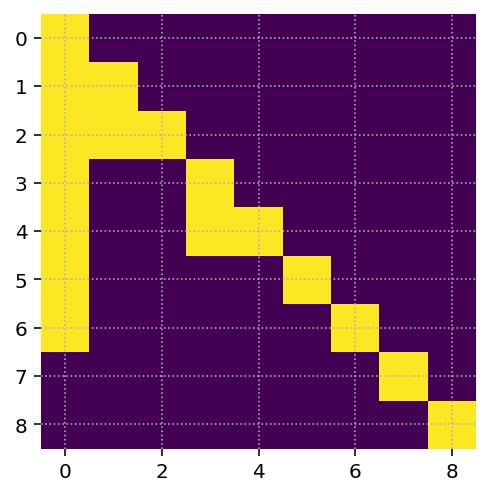

In [205]:
A = ancestor_matrix(merged_lineages)
plt.imshow(A)

### Cases
Also from RKI

In [206]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [207]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-19   
                                    2020-03-13  2020-03-21   
            A35-A59      M          2020-03-16  2020-03-14   
            A15-A34      M          2020-03-16  2020-03-19   
...                                                    ...   
16077       A35-A59      W          2022-04-28  2022-04-28   
            A15-A34      W          2022-04-28  2022-04-28   
            A60-A79      W          2022-04-28  2022-04-28   
                                    2022-04-29  2022-04-29   
            A80+         W          2022-04-29  2022-04-29   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
            A35-A59      M          2020-03-16                     1   
            A15-A34      M          2020-03-16                     1   
...                                                              ...   
16077       A35-A59      W          2022-04-28                     0   
            A15-A34      W          2022-04-28                     0   
            A60-A79      W          2022-04-28                     0   
                                    2022-04-29                     0   
            A80+         W          2022-04-29                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
            A35-A59      M          2020-03-16          0              -9   
            A15-A34      M          2020-03-16          0              -9   
...                                                   ...             ...   
16077       A35-A59      W          2022-04-28          0              -9   
            A15-A34      W          2022-04-28          0              -9   
            A60-A79      W          2022-04-28          0              -9   
                                    2022-04-29          0              -9   
            A80+         W          2022-04-29          0              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
            A35-A59      M          2020-03-16           0           1   
            A15-A34      M          2020-03-16           0           1   
...                                                    ...         ...   
16077       A35-A59      W          2022-04-28          -9          20   
            A15-A34      W          2022-04-28          -9           6   
            A60-A79      W          2022-04-28          -9           9   
                                    2022-04-29          -9           1   
            A80+         W          2022-04-29          -9           1   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

### Registration delays

In [208]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

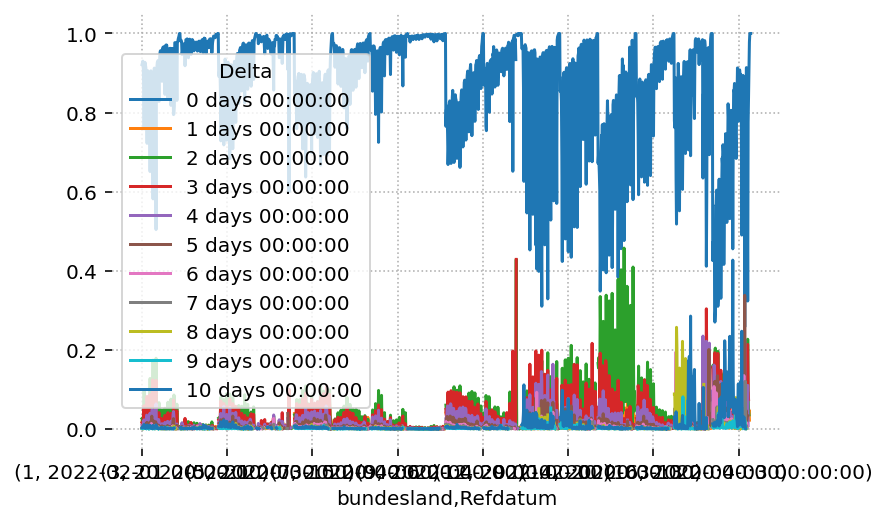

In [209]:
f.plot()

In [210]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [211]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [212]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Tue             0.941311         0.956326         0.977130         0.988702   
Wed             0.940669         0.957213         0.977205         0.984067   
Thu             0.941792         0.958669         0.969917         0.972212   
Fri             0.928998         0.939838         0.946647         0.965331   
Sat             0.861988         0.862603         0.902493         0.953996   
Sun             0.773284         0.794941         0.887637         0.947541   
Mon             0.909499         0.932101         0.963077         0.981664   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Tue             0.992093         0.992563         0.995446         0.997246   
Wed             0.985193         0.991278         0.995601         0.997546   
Thu             0.983443         0.992626         0.996202         0.997597   
Fri             0.983736         0.992137         0.995392         0.996968   
Sat             0.979706         0.989689         0.993483         0.993911   
Sun             0.974259         0.984973         0.986417         0.987926   
Mon             0.990629         0.993053         0.993551         0.995507   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Tue             0.998090         0.998594               1.0  
Wed             0.998455         0.998754               1.0  
Thu             0.998203         0.998137               1.0  
Fri             0.996974         0.996561               1.0  
Sat             0.994274         0.996074               1.0  
Sun             0.991687         0.994449               1.0  
Mon             0.997003         0.998120               1.0

In [213]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [214]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [215]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999742  0.999234  0.999270  0.999052  0.998880   
Bayern                  0.995158  0.990166  0.985835  0.980901  0.970958   
Berlin                  0.973755  0.916163  0.983536  0.970554  0.978917   
Brandenburg             0.960195  0.921369  0.971730  0.978187  0.976164   
Bremen                  0.995876  0.996500  0.995769  0.992901  0.990640   
Hamburg                 0.998109  0.994148  0.995543  0.994307  0.992683   
Hessen                  0.998622  0.996471  0.996297  0.995845  0.992661   
Mecklenburg-Vorpommern  0.996873  0.991703  0.990762  0.992482  0.985150   
Niedersachsen           0.988654  0.975722  0.980379  0.983770  0.978045   
Nordrhein-Westfalen     0.994038  0.988178  0.985287  0.982563  0.973240   
Rheinland-Pfalz         0.997658  0.994186  0.997018  0.995194  0.993882   
Saarland                0.995708  0.992231  0.992472  0.995278  0.993214   
Sachsen                 0.997362  0.995082  0.994747  0.993764  0.987038   
Sachsen-Anhalt          0.946797  0.832748  0.882824  0.906006  0.927120   
Schleswig-Holstein      0.994274  0.987926  0.993551  0.992563  0.985193   
Thüringen               0.910235  0.856485  0.854060  0.881227  0.869338   

                               5         6         7         8  
Baden-Württemberg       0.998111  0.996476  0.992298  0.984869  
Bayern                  0.948312  0.895068  0.822935  0.730294  
Berlin                  0.966669  0.924237  0.755022  0.523800  
Brandenburg             0.964876  0.930261  0.830521  0.572122  
Bremen                  0.990768  0.974689  0.960870  0.961447  
Hamburg                 0.990645  0.983225  0.962371  0.963332  
Hessen                  0.987381  0.971423  0.937563  0.866278  
Mecklenburg-Vorpommern  0.969776  0.924929  0.735918  0.525742  
Niedersachsen           0.969021  0.950059  0.904814  0.791531  
Nordrhein-Westfalen     0.958222  0.922416  0.853786  0.738540  
Rheinland-Pfalz         0.991345  0.982266  0.957246  0.887673  
Saarland                0.985467  0.970426  0.946427  0.853324  
Sachsen                 0.974745  0.934169  0.872155  0.770831  
Sachsen-Anhalt          0.954387  0.904407  0.788323  0.734211  
Schleswig-Holstein      0.972212  0.946647  0.862603  0.773284  
Thüringen               0.842020  0.744938  0.676075  0.495068

In [216]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [217]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg           2146.0      2959.0      4420.0      4618.0   
Bayern                      5967.0      7036.0      9188.0      8952.0   
Berlin                      1323.0      1322.0      1441.0      1434.0   
Brandenburg                  816.0       983.0      1074.0      1055.0   
Bremen                        79.0        89.0        69.0        62.0   
Hamburg                      322.0       455.0       539.0       508.0   
Hessen                      1194.0      1596.0      1705.0      1574.0   
Mecklenburg-Vorpommern       418.0       428.0       405.0       317.0   
Niedersachsen               1189.0      1457.0      1673.0      1369.0   
Nordrhein-Westfalen         2564.0      3469.0      4353.0      4361.0   
Rheinland-Pfalz              651.0       996.0      1131.0      1060.0   
Saarland                     127.0       123.0       203.0       230.0   
Sachsen                     2840.0      3671.0      3484.0      3323.0   
Sachsen-Anhalt               647.0       855.0       722.0       738.0   
Schleswig-Holstein           336.0       389.0       367.0       354.0   
Thüringen                   1823.0      1431.0      1425.0      1502.0   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg           5070.0      4127.0      2276.0      4391.0   
Bayern                      9272.0      8810.0      7254.0      9354.0   
Berlin                      1451.0       969.0       755.0      2177.0   
Brandenburg                 1188.0      1119.0       985.0      1263.0   
Bremen                        55.0        55.0        31.0        60.0   
Hamburg                      556.0       470.0       411.0       483.0   
Hessen                      1689.0      1312.0      1093.0      1468.0   
Mecklenburg-Vorpommern       543.0       504.0       314.0       528.0   
Niedersachsen               1402.0      1164.0       846.0      1622.0   
Nordrhein-Westfalen         4080.0      3723.0      2977.0      4442.0   
Rheinland-Pfalz             1030.0       798.0       770.0      1075.0   
Saarland                     185.0       214.0       155.0       209.0   
Sachsen                     3462.0      3211.0      2691.0      4473.0   
Sachsen-Anhalt               729.0       659.0       899.0       669.0   
Schleswig-Holstein           435.0       383.0       298.0       449.0   
Thüringen                   1430.0      1755.0      1191.0      1859.0   

Refdatum                2021-11-09  2021-11-10  ...  2022-04-22  2022-04-23  \
bundesland                                      ...                           
Baden-Württemberg           7120.0      7754.0  ...     14451.0      4858.0   
Bayern                     11258.0     12177.0  ...     14971.0     11559.0   
Berlin                      1922.0      2400.0  ...      2820.0       657.0   
Brandenburg                 1497.0      1689.0  ...      2478.0       428.0   
Bremen                       143.0        95.0  ...      1264.0       673.0   
Hamburg                      531.0       566.0  ...      3697.0      1921.0   
Hessen                      1791.0      2064.0  ...      9931.0      5433.0   
Mecklenburg-Vorpommern       597.0       468.0  ...      1935.0       983.0   
Niedersachsen               1753.0      2167.0  ...     19558.0      7698.0   
Nordrhein-Westfalen         5159.0      5331.0  ...     23184.0     12540.0   
Rheinland-Pfalz             1135.0      1327.0  ...      6327.0      1716.0   
Saarland                     273.0       301.0  ...      1433.0      1142.0   
Sachsen                     5756.0      5979.0  ...      3892.0      1214.0   
Sachsen-Anhalt              1019.0      1178.0  ...      2682.0      1002.0   
Schleswig-Holstein           487.0       542.0  ...      5302.0      1

In [218]:
cases_land.sum(0)

Refdatum
2021-11-01     22442.0
2021-11-02     27259.0
2021-11-03     32199.0
2021-11-04     31457.0
2021-11-05     32577.0
                ...   
2022-04-27    109287.0
2022-04-28     87436.0
2022-04-29     57060.0
2022-04-30      8160.0
2022-05-01      1886.0
Length: 182, dtype: float64

In [219]:
clip = 1
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg           2146.0      2959.0      4420.0      4618.0   
Bayern                      5967.0      7036.0      9188.0      8952.0   
Berlin                      1323.0      1322.0      1441.0      1434.0   
Brandenburg                  816.0       983.0      1074.0      1055.0   
Bremen                        79.0        89.0        69.0        62.0   
Hamburg                      322.0       455.0       539.0       508.0   
Hessen                      1194.0      1596.0      1705.0      1574.0   
Mecklenburg-Vorpommern       418.0       428.0       405.0       317.0   
Niedersachsen               1189.0      1457.0      1673.0      1369.0   
Nordrhein-Westfalen         2564.0      3469.0      4353.0      4361.0   
Rheinland-Pfalz              651.0       996.0      1131.0      1060.0   
Saarland                     127.0       123.0       203.0       230.0   
Sachsen                     2840.0      3671.0      3484.0      3323.0   
Sachsen-Anhalt               647.0       855.0       722.0       738.0   
Schleswig-Holstein           336.0       389.0       367.0       354.0   
Thüringen                   1823.0      1431.0      1425.0      1502.0   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg           5070.0      4127.0      2276.0      4391.0   
Bayern                      9272.0      8810.0      7254.0      9354.0   
Berlin                      1451.0       969.0       755.0      2177.0   
Brandenburg                 1188.0      1119.0       985.0      1263.0   
Bremen                        55.0        55.0        31.0        60.0   
Hamburg                      556.0       470.0       411.0       483.0   
Hessen                      1689.0      1312.0      1093.0      1468.0   
Mecklenburg-Vorpommern       543.0       504.0       314.0       528.0   
Niedersachsen               1402.0      1164.0       846.0      1622.0   
Nordrhein-Westfalen         4080.0      3723.0      2977.0      4442.0   
Rheinland-Pfalz             1030.0       798.0       770.0      1075.0   
Saarland                     185.0       214.0       155.0       209.0   
Sachsen                     3462.0      3211.0      2691.0      4473.0   
Sachsen-Anhalt               729.0       659.0       899.0       669.0   
Schleswig-Holstein           435.0       383.0       298.0       449.0   
Thüringen                   1430.0      1755.0      1191.0      1859.0   

Refdatum                2021-11-09  2021-11-10  ...  2022-04-21  2022-04-22  \
bundesland                                      ...                           
Baden-Württemberg           7120.0      7754.0  ...     17677.0     14451.0   
Bayern                     11258.0     12177.0  ...     22238.0     14971.0   
Berlin                      1922.0      2400.0  ...      3233.0      2820.0   
Brandenburg                 1497.0      1689.0  ...      3371.0      2478.0   
Bremen                       143.0        95.0  ...      1659.0      1264.0   
Hamburg                      531.0       566.0  ...      4492.0      3697.0   
Hessen                      1791.0      2064.0  ...     12713.0      9931.0   
Mecklenburg-Vorpommern       597.0       468.0  ...      2278.0      1935.0   
Niedersachsen               1753.0      2167.0  ...     24127.0     19558.0   
Nordrhein-Westfalen         5159.0      5331.0  ...     28708.0     23184.0   
Rheinland-Pfalz             1135.0      1327.0  ...      8453.0      6327.0   
Saarland                     273.0       301.0  ...      1986.0      1433.0   
Sachsen                     5756.0      5979.0  ...      5414.0      3892.0   
Sachsen-Anhalt              1019.0      1178.0  ...      3896.0      2682.0   
Schleswig-Holstein           487.0       542.0  ...      7280.0      5

In [220]:
C = cases_land.values

### Population data
From Destatis

In [221]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [222]:
131 % 10

1

## Modeling
### Basis functions

In [223]:
from genomicsurveillance.misc import fused_basis
n = C.shape[1]+clip
B0 = fused_basis(n+2, inc=10, fuse=4, pad=28 - n % 10) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 
#B0 = fused_basis(n+2, inc=7, fuse=5, pad=30 - n % 7)## cubic spline basis every 7d, last 5 linearly fused to avoid wriggles 
B0 = np.stack([B0[0,2:,:],B0[1,:-2,:]])

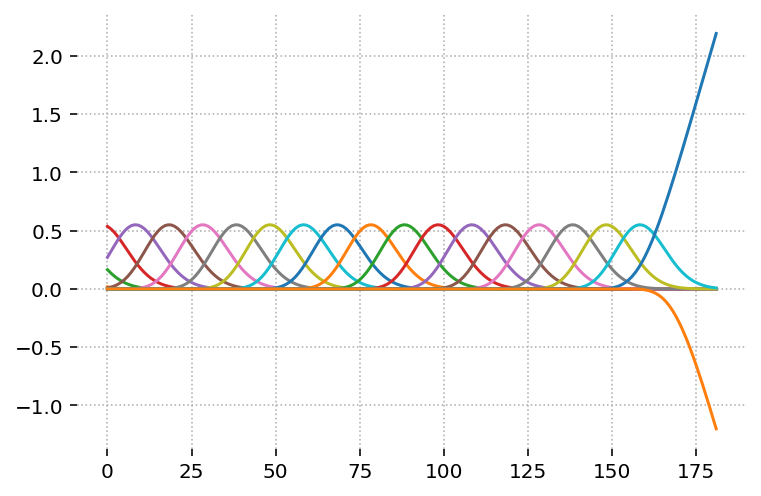

In [224]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

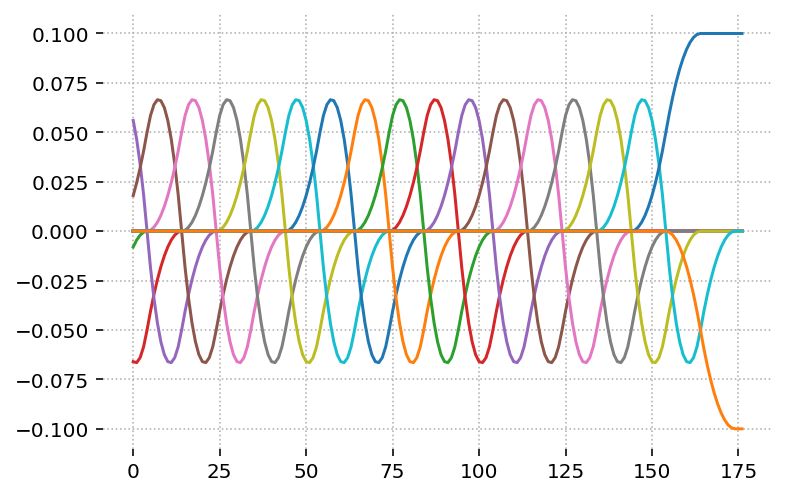

In [225]:
for i in range(B0.shape[-1]):
    plt.plot(B0[1,:-5,i])

In [226]:
B0.shape

(2, 182, 22)

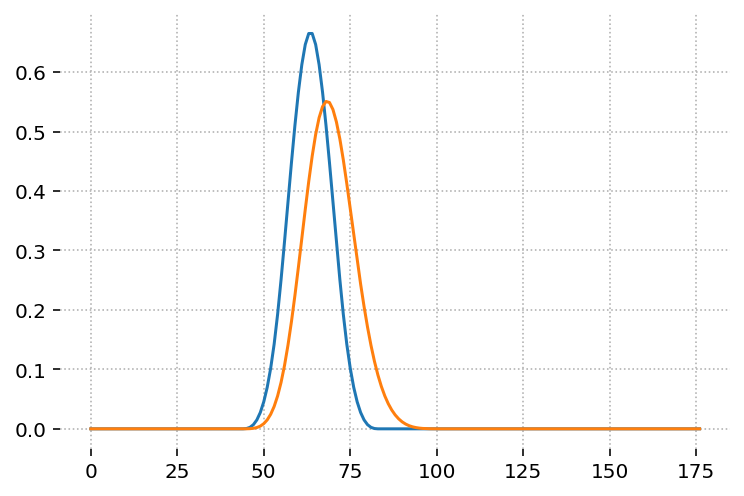

In [227]:
plt.plot(B0[1,:-5,10].cumsum())
plt.plot(B0[0,:-5,10])


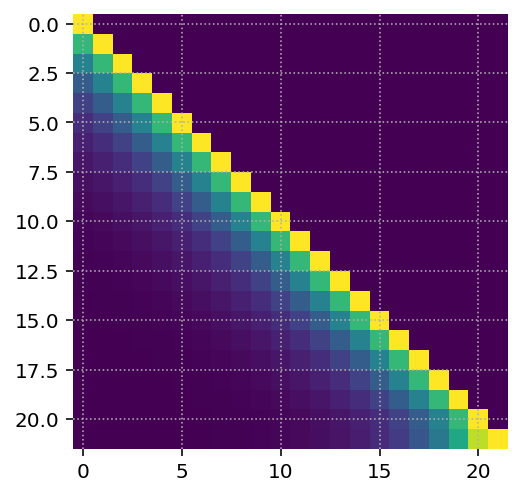

In [228]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.667
arma2[-1,-2] = -.9
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

### Case and genome data
Prepare as arrays and add Germany as a whole

In [229]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [230]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [231]:
from numpyro.infer import Trace_ELBO

In [232]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

In [233]:
CC[2,cases_land.columns == np.datetime64("2022-03-08")] = np.nan # int women's day in Berlin..

### Model
Multi-lineage model with variable growth rates (random effect) across states

In [313]:
model = MultiLineageTimeShift(
    CC,
    GG,    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)]),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.01,
    b0_scale=0.3,
    c_scale=20,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=100., 
    week=True,
    fit_logits=True,
    ancestor_matrix=A,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=100), 'num_epochs':2000, 'lr':0.05, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [314]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 2,000 | 0 %
SVI step 1,000 / 2,000 | 50 %


Text(0, 0.5, 'ELBO')

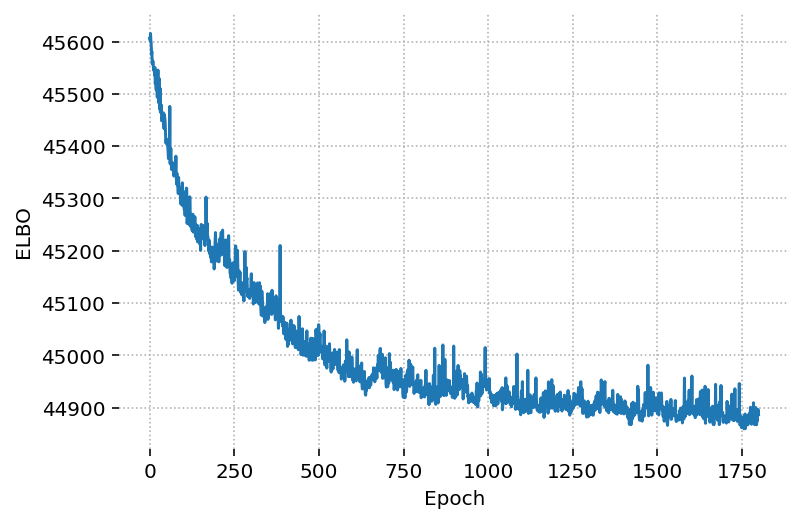

In [318]:
plt.plot(model.loss[200:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((None, model.loss[2000]))

In [316]:
merged_lineages

['B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.4',
 'B.1.1.529.5',
 'Other',
 'B.1.617.2']

<Figure size 432x288 with 0 Axes>

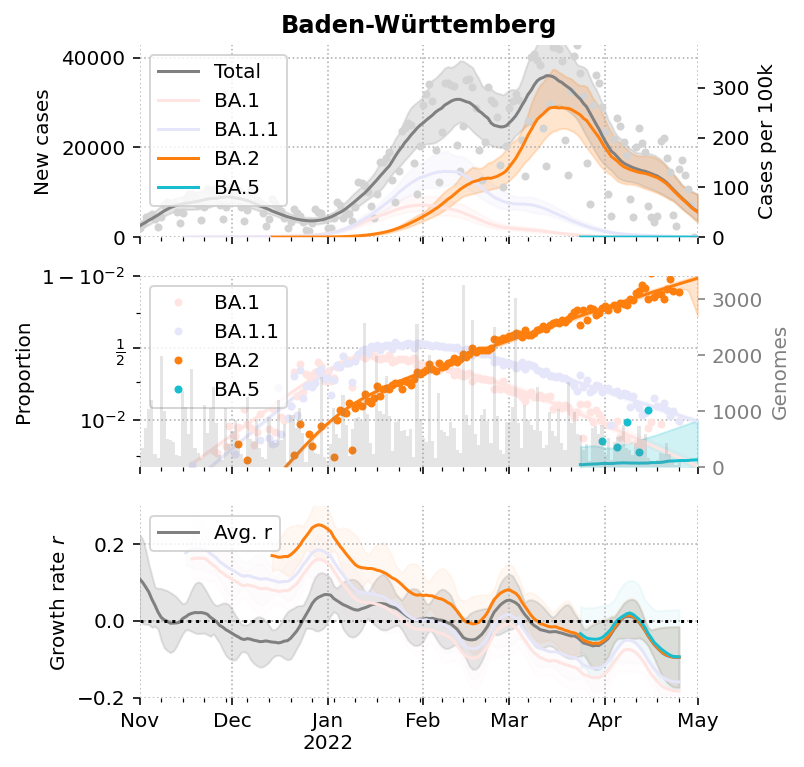

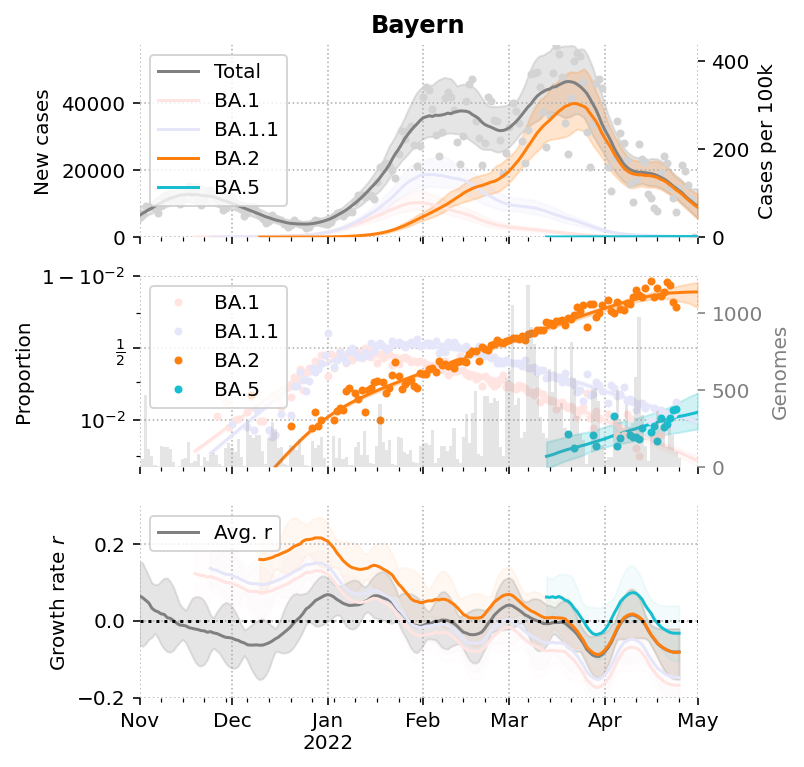

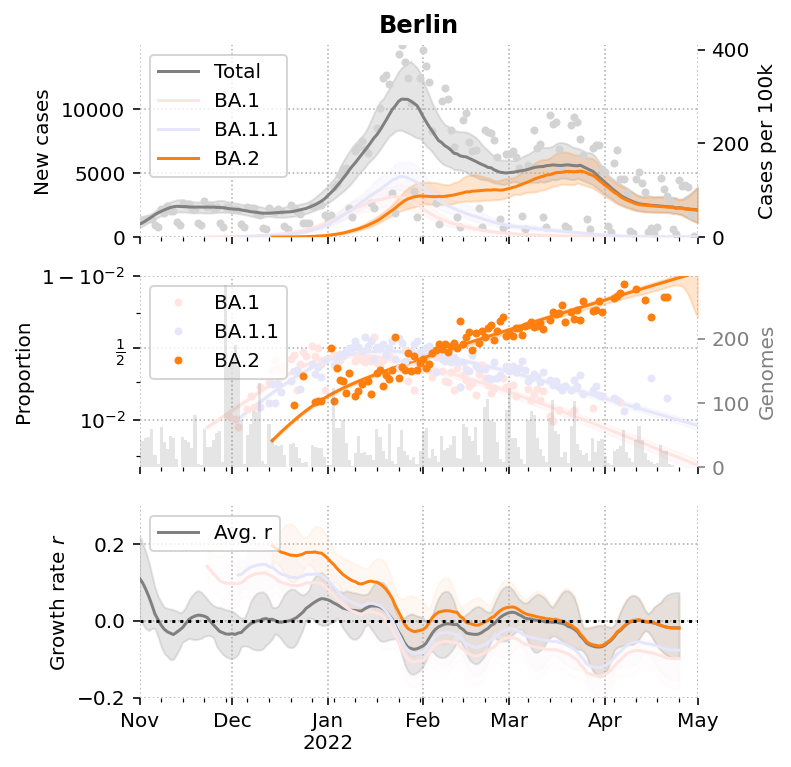

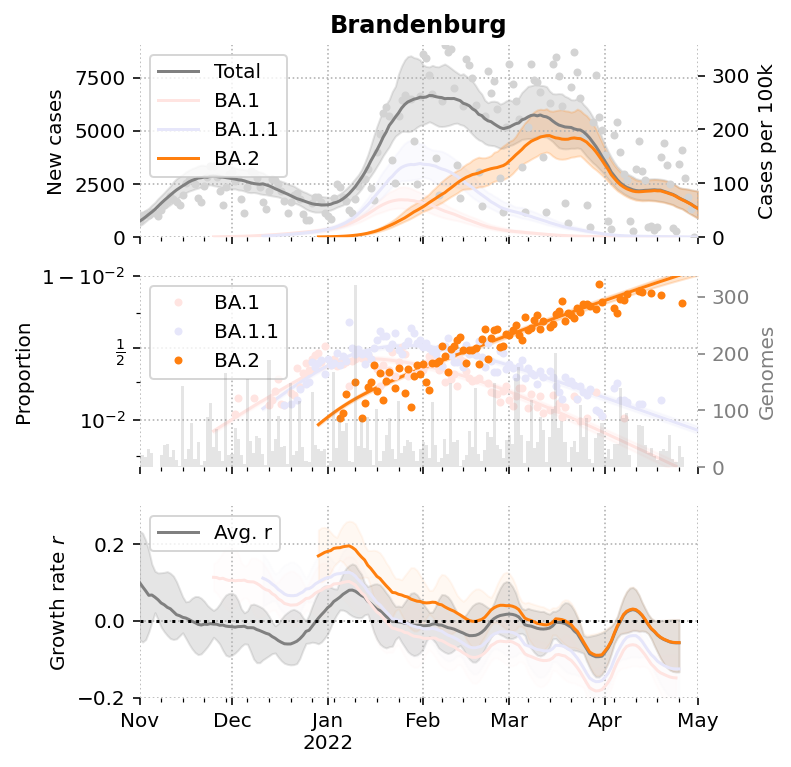

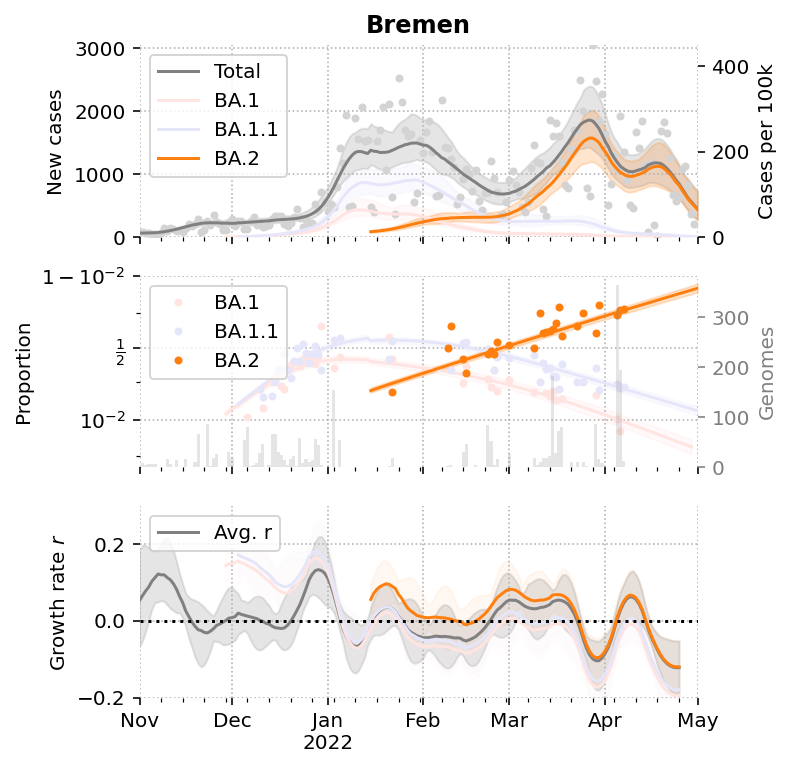

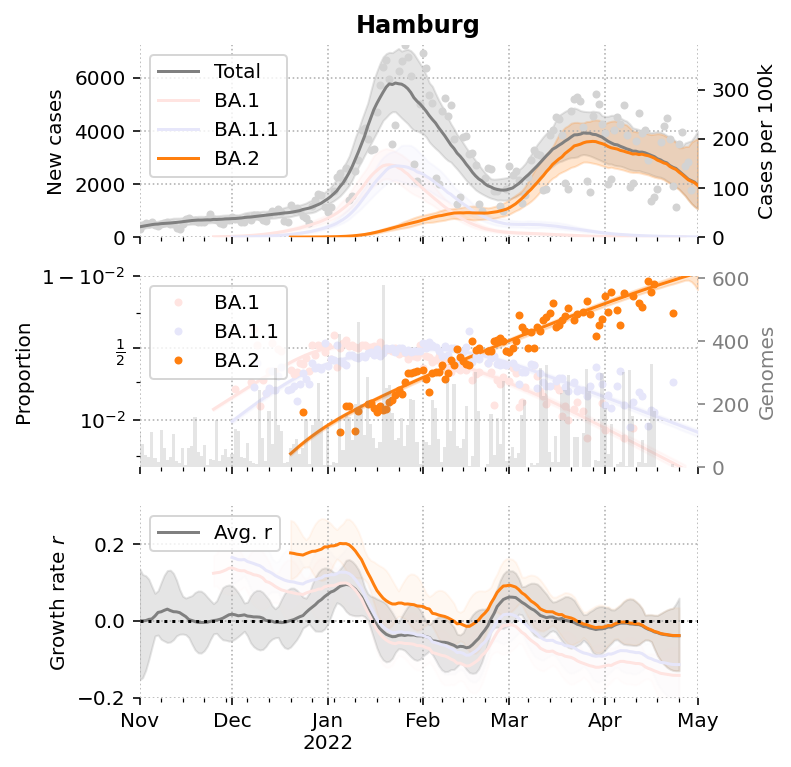

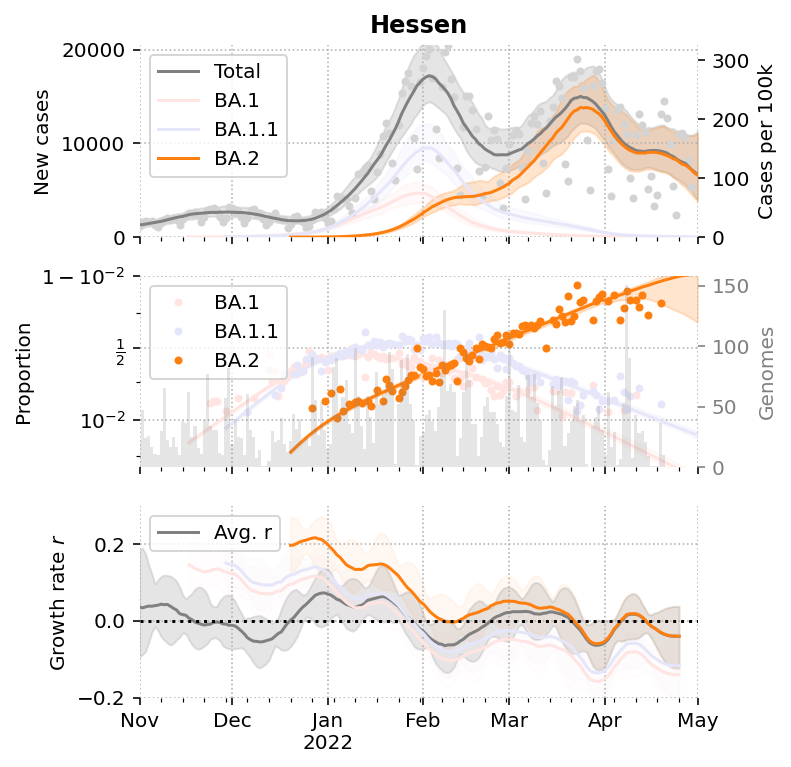

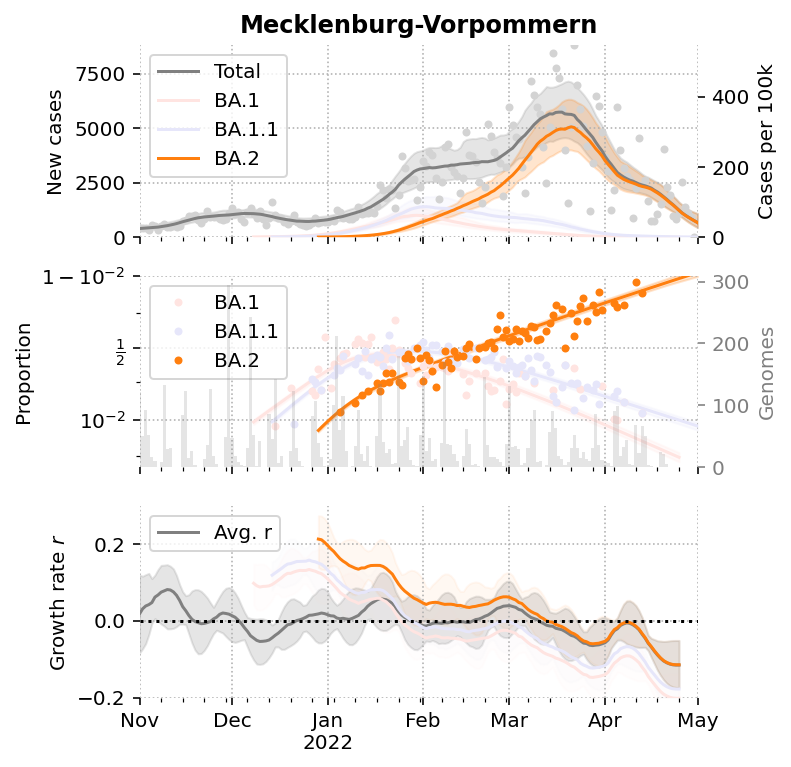

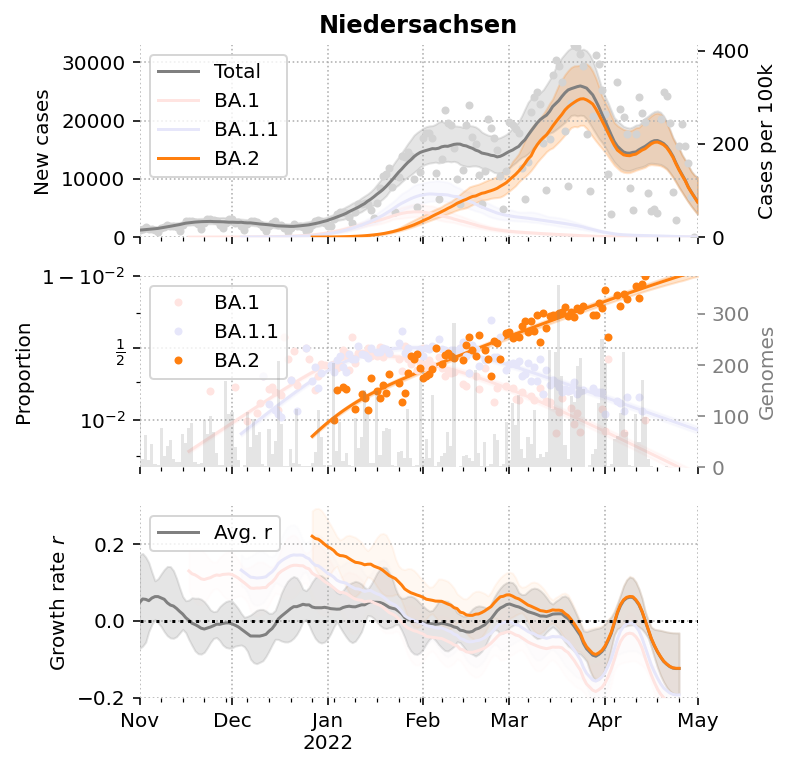

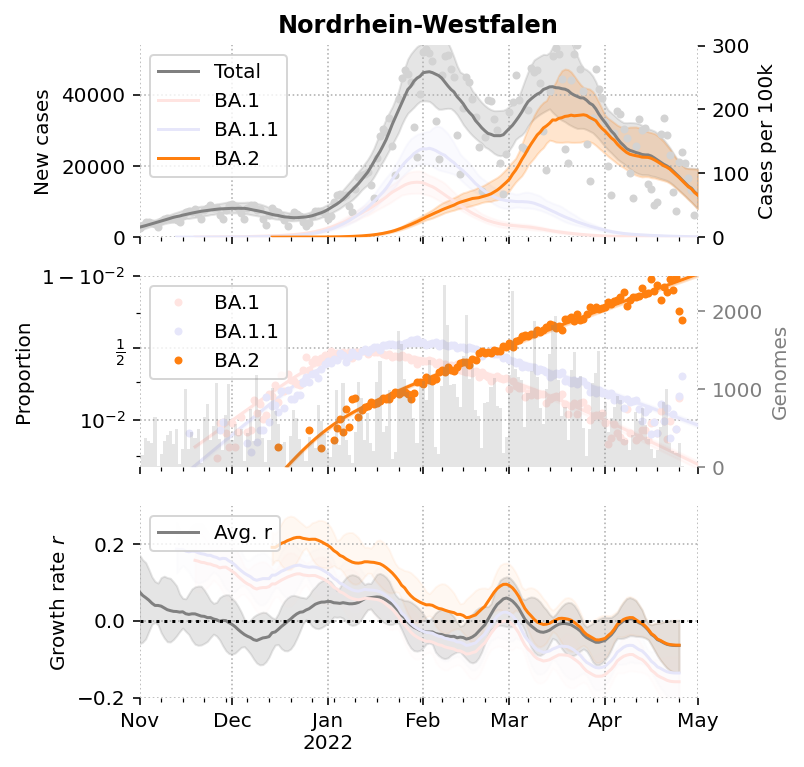

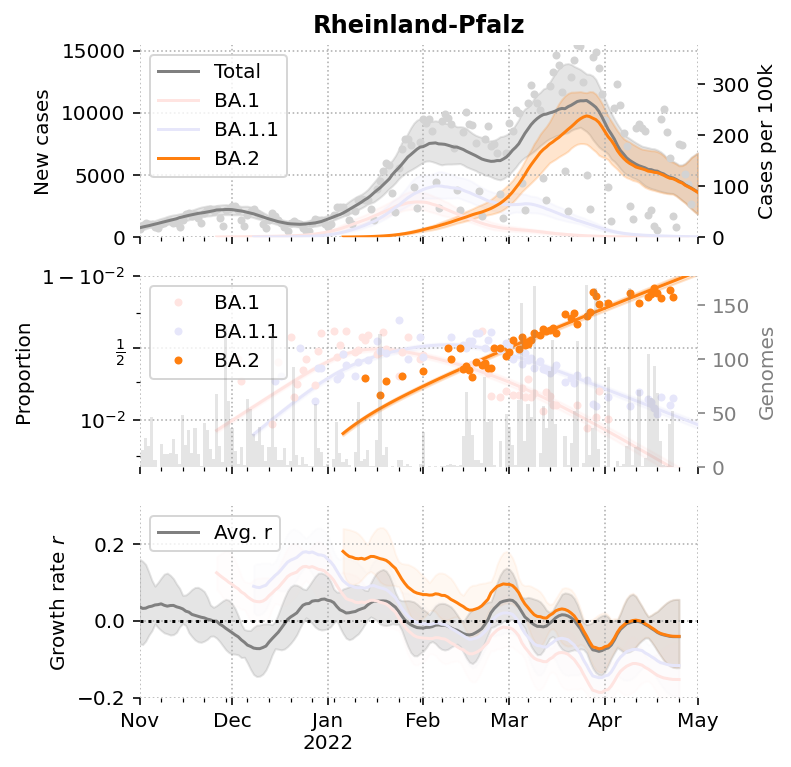

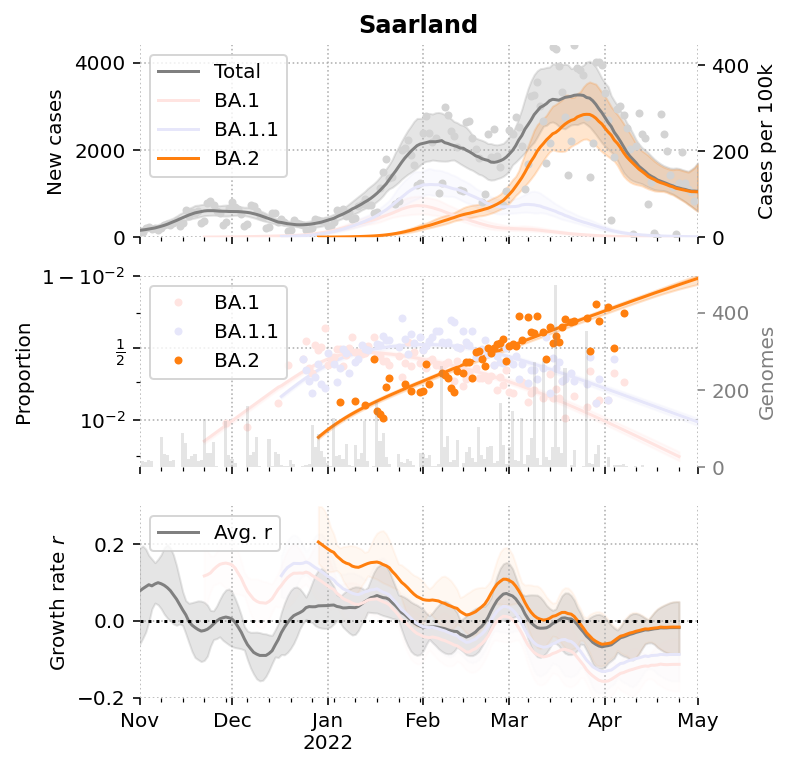

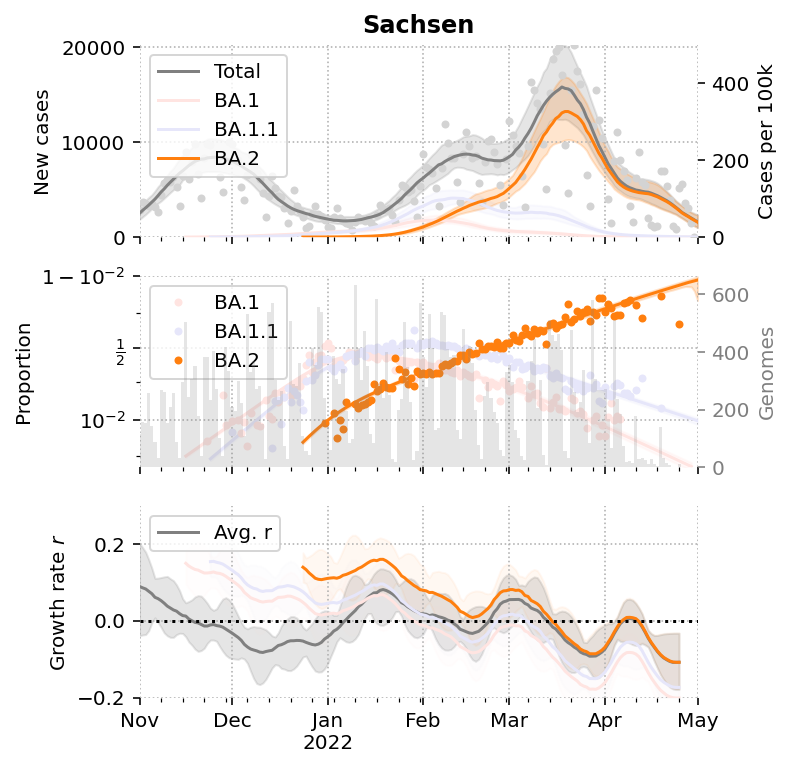

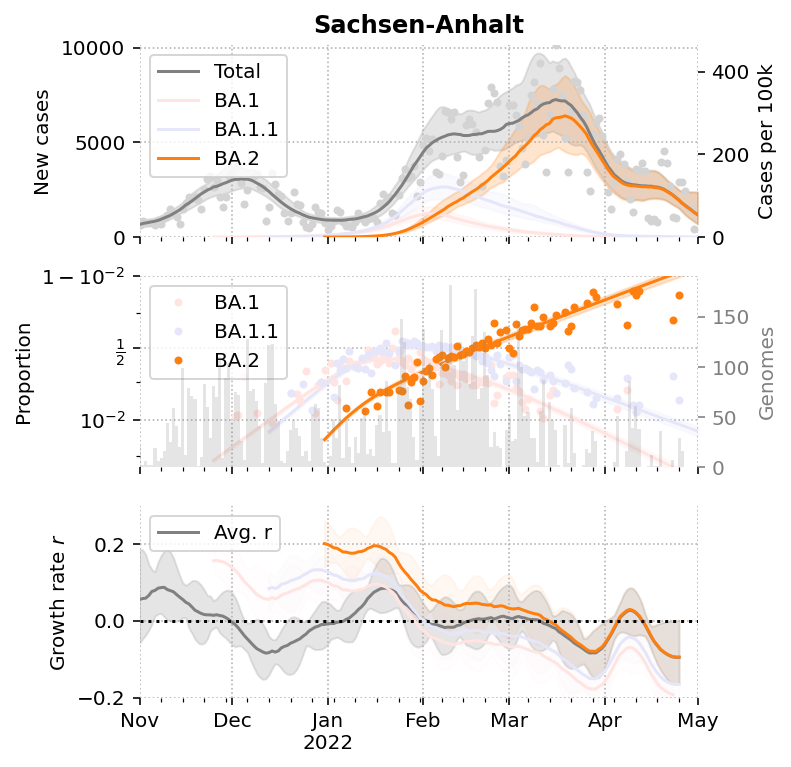

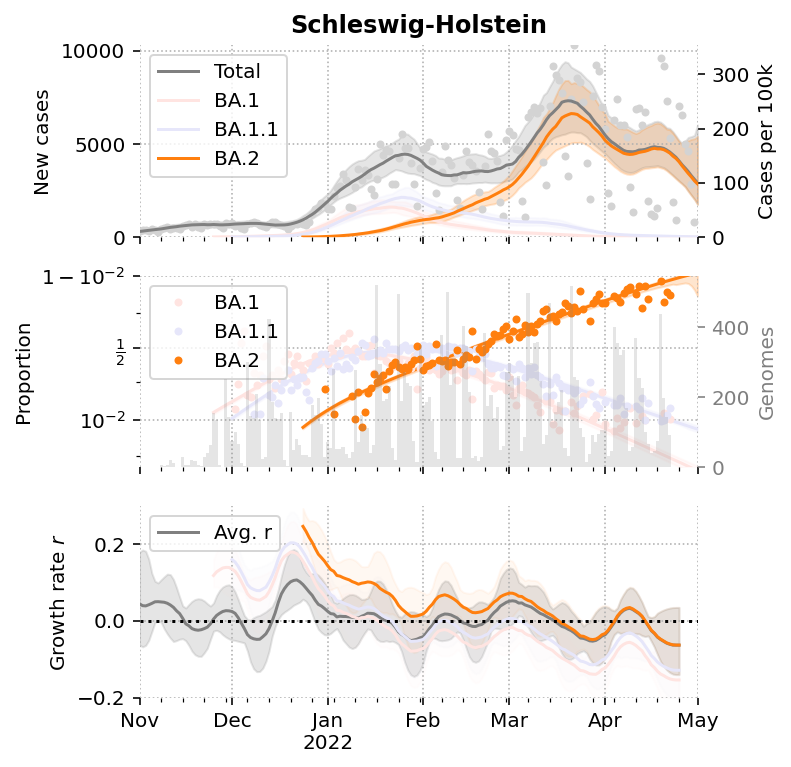

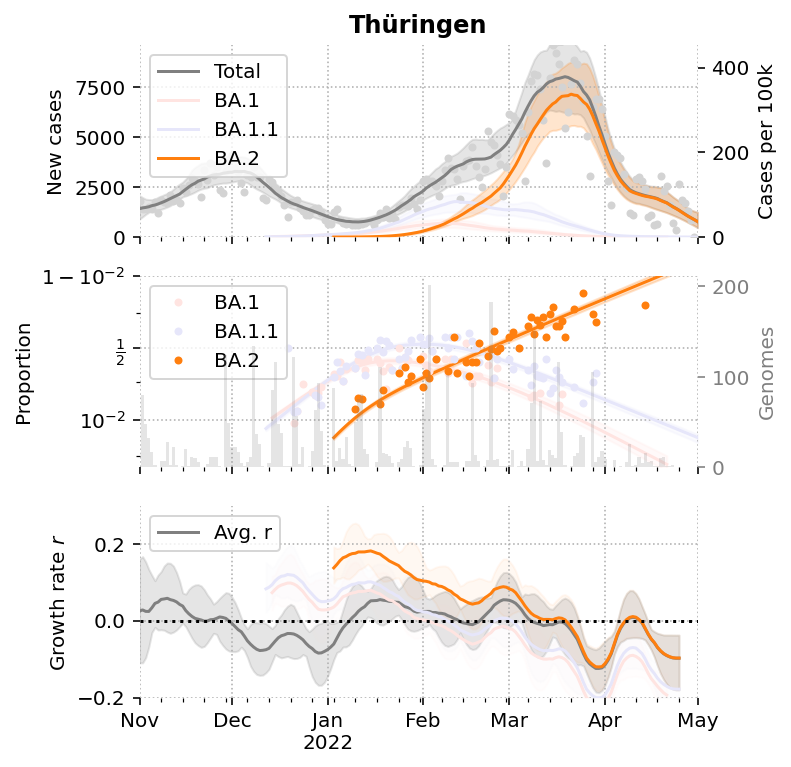

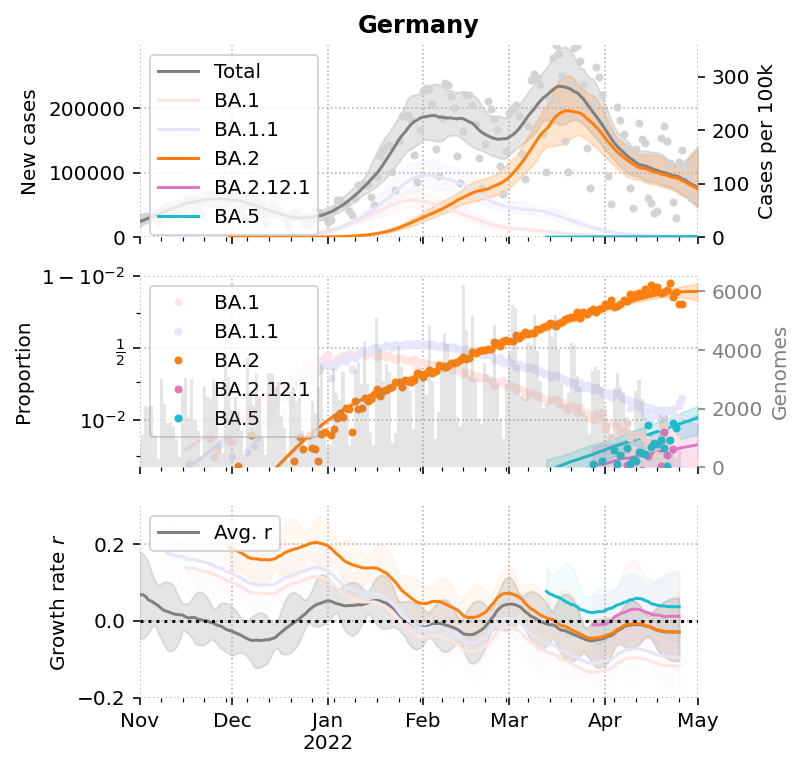

In [442]:
#from genomicsurveillance.plots.england import plot_lad, 
from genomicsurveillance.plots.england import plot_median_and_ci
for i,r in enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 10)[0]
    w = list(set(w) - set([0,GG.shape[2]-2,GG.shape[2]-1]))
    plt.set_cmap("tab20")
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = np.array([alias(x) for x in merged_lineages])[w],#genomes.columns[w],
        #lin_colors=np.array(5*['C7','C3',"C4","C1", "C6","C8" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
        lin_colors=np.array(5*['C7','mistyrose',"lavender","C1", "C6","C8" ,"C9", "C7","aliceblue"])[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    #ax[0].set_yscale('log')
    #ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[0].set_ylim((0, np.nanmax(CC[i,:])))
    ax[1].set_yscale("logit")
    ax[1].set_ylim((5e-4,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")

In [284]:
np.quantile(model.get_probabilities()[:,1,-1:,5], (0.025,0.5,0.975))

array([4.97479494e-24, 6.00850505e-13, 9.66161734e-01])

In [450]:
f = pd.DataFrame(GG.sum(1), index=cases_land.index.to_list() + ["Germany"], columns=[alias(x) for x in merged_lineages])

In [445]:
f

B.1.1.529  B.1.1.529.1  B.1.1.529.1.1  B.1.1.529.2  \
Baden-Württemberg           112.0      14285.0        28644.0      39595.0   
Bayern                       18.0       3087.0         7151.0      20527.0   
Berlin                        6.0        661.0          979.0       2545.0   
Brandenburg                   3.0        901.0         1656.0       3452.0   
Bremen                        2.0        225.0          558.0       1091.0   
Hamburg                      26.0       4021.0         4074.0       6250.0   
Hessen                        5.0        997.0         1817.0       2247.0   
Mecklenburg-Vorpommern       16.0        759.0         1002.0       1926.0   
Niedersachsen                 6.0        929.0         1615.0       4522.0   
Nordrhein-Westfalen         174.0      16821.0        30896.0      46464.0   
Rheinland-Pfalz               5.0        368.0          733.0       2138.0   
Saarland                     28.0        904.0         1656.0       2316.0   
Sachsen                      69.0       5327.0         9267.0      11646.0   
Sachsen-Anhalt                5.0        806.0         1780.0       2232.0   
Schleswig-Holstein           10.0       3423.0         5406.0      11515.0   
Thüringen                     4.0        353.0          812.0       1046.0   
Germany                     489.0      53867.0        98046.0     159512.0   

                        B.1.1.529.2.12.1  B.1.1.529.4  B.1.1.529.5   Other  \
Baden-Württemberg                    3.0          2.0         10.0   152.0   
Bayern                               3.0          6.0         39.0   127.0   
Berlin                               0.0          0.0          1.0    14.0   
Brandenburg                          0.0          0.0          0.0    10.0   
Bremen                               0.0          0.0          0.0    17.0   
Hamburg                              0.0          0.0          1.0   138.0   
Hessen                               3.0          0.0          1.0     6.0   
Mecklenburg-Vorpommern               0.0          0.0          0.0     8.0   
Niedersachsen                        0.0          0.0          2.0    26.0   
Nordrhein-Westfalen                  5.0          1.0          5.0   823.0   
Rheinland-Pfalz                      0.0          0.0          0.0     6.0   
Saarland                             0.0          0.0          0.0    43.0   
Sachsen                              0.0          0.0          1.0   176.0   
Sachsen-Anhalt                       0.0          0.0          0.0     7.0   
Schleswig-Holstein                   4.0          0.0          3.0    35.0   
Thüringen                            0.0          0.0          1.0    31.0   
Germany                             18.0          9.0         64.0  1619.0   

                        B.1.617.2  
Baden-Württemberg         41428.0  
Bayern                     6247.0  
Berlin                     2894.0  
Brandenburg                2852.0  
Bremen                      837.0  
Hamburg                    3787.0  
Hessen                     1646.0  
Mecklenburg-Vorpommern     2866.0  
Niedersachsen              3021.0  
Nordrhein-Westfalen       26473.0  
Rheinland-Pfalz            1514.0  
Saarland                   1783.0  
Sachsen                   15319.0  
Sachsen-Anhalt             3004.0  
Schleswig-Holstein         3912.0  
Thüringen                  1717.0  
Germany                  119300.0

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Baden-Württemberg'),
  Text(1, 0, 'Bayern'),
  Text(2, 0, 'Berlin'),
  Text(3, 0, 'Brandenburg'),
  Text(4, 0, 'Bremen'),
  Text(5, 0, 'Hamburg'),
  Text(6, 0, 'Hessen'),
  Text(7, 0, 'Mecklenburg-Vorpommern'),
  Text(8, 0, 'Niedersachsen'),
  Text(9, 0, 'Nordrhein-Westfalen'),
  Text(10, 0, 'Rheinland-Pfalz'),
  Text(11, 0, 'Saarland'),
  Text(12, 0, 'Sachsen'),
  Text(13, 0, 'Sachsen-Anhalt'),
  Text(14, 0, 'Schleswig-Holstein'),
  Text(15, 0, 'Thüringen')])

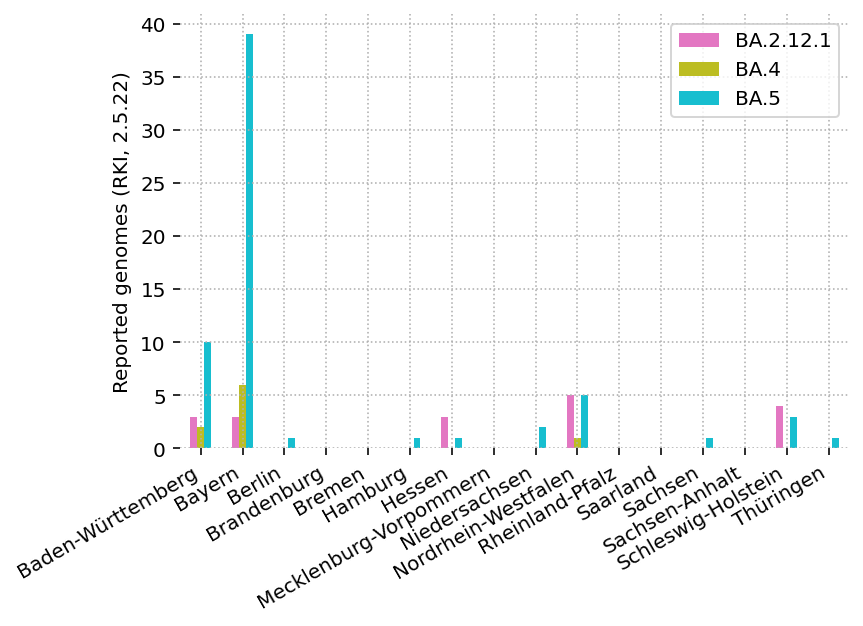

In [465]:
f.iloc[:-1,:].loc[:,["BA.2.12.1","BA.4","BA.5"]].plot.bar(color=["C6","C8" ,"C9"])
plt.ylabel("Reported genomes (RKI, 2.5.22)")
plt.xticks(rotation=30, ha='right')

In [144]:
model.posterior['b1'].mean(0)[-1,0,:]

array([ 0.18212476,  0.12897569,  0.15241767,  0.21802427,  0.11249743,
       -0.04616144,  0.24923223,  0.1762545 ,  0.        ], dtype=float32)

In [134]:
f = model.params['bc0_loc'].reshape(2,-1)[0,:]/100
f = np.append(f, -A[-1,:-1] @ f / A[-1,-1])
A @ f

array([0.08401144, 0.11255571, 0.13582318, 0.14824785, 0.12757898,
       0.14032482, 0.1553765 , 0.1357434 , 0.13072744, 0.09990139,
       0.12529667, 0.10974146, 0.12262245, 0.11771224, 0.12031139,
       0.11175881, 0.12309166, 0.14611382, 0.20461828, 0.21142982,
       0.12769383, 0.        ])

In [116]:
pd.Series(np.diff(model.get_logits().mean(0)[-1,-2:,:], axis=0)[0], index=merged_lineages)

B.1.1.529           0.114305
B.1.1.529.1         0.126160
B.1.1.529.1.1       0.147561
B.1.1.529.1.1.1     0.149255
B.1.1.529.1.1.11    0.137481
B.1.1.529.1.1.13    0.155252
B.1.1.529.1.1.14    0.150502
B.1.1.529.1.1.15    0.137701
B.1.1.529.1.1.16    0.148684
B.1.1.529.1.8       0.116421
B.1.1.529.1.12      0.143390
B.1.1.529.1.13      0.114300
B.1.1.529.1.14      0.135708
B.1.1.529.1.15      0.122296
B.1.1.529.1.15.1    0.128639
B.1.1.529.1.16      0.127284
B.1.1.529.1.17      0.126047
B.1.1.529.2         0.212582
B.1.1.529.2.1       0.214573
B.1.1.529.2.3       0.205985
Other               0.162435
B.1.617.2           0.000000
dtype: float32

In [47]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

0.9999999999999998

In [48]:
model.posterior.keys()

dict_keys(['b1', 'b_scale_lin', 'bc0', 'beta1', 'c1', 't', 'b0'])

Text(0.5, 1.0, 'Germany')

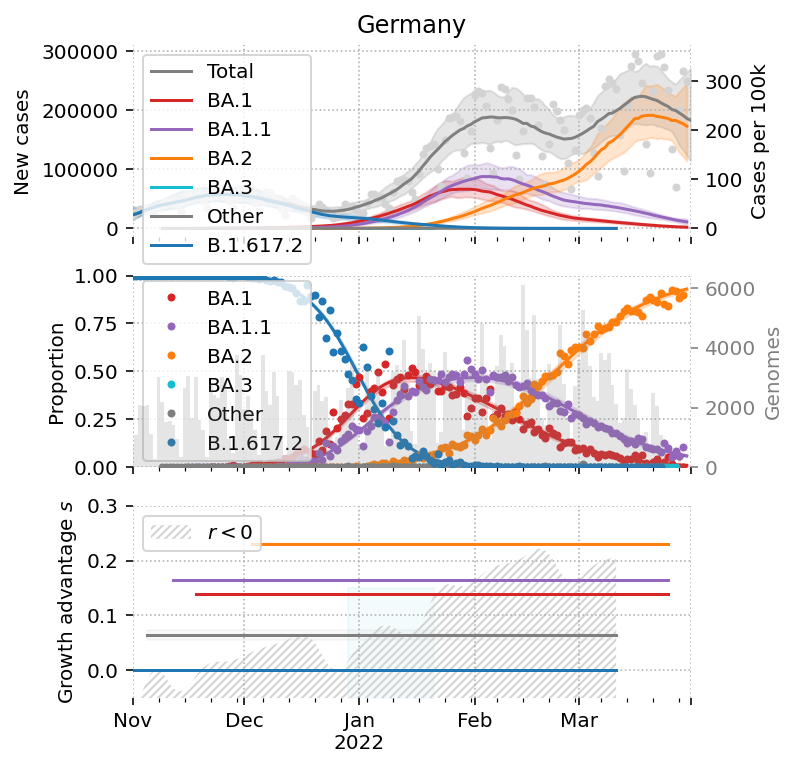

In [49]:
w = np.arange(genomes.shape[-1])
plot_lad(model, -1, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
            bleed_left = 1,
             bleed_right=6,
             show_Rt = False,
             plot_s= True
            )
plt.gcf().get_axes()[2].set_ylim(-0.05,0.3)
plt.gcf().get_axes()[0].set_title("Germany")

In [379]:
λ = np.median(model.get_lambda_lineage(),0) / model.population[:,np.newaxis, np.newaxis]

In [380]:
λ.shape

(17, 182, 9)

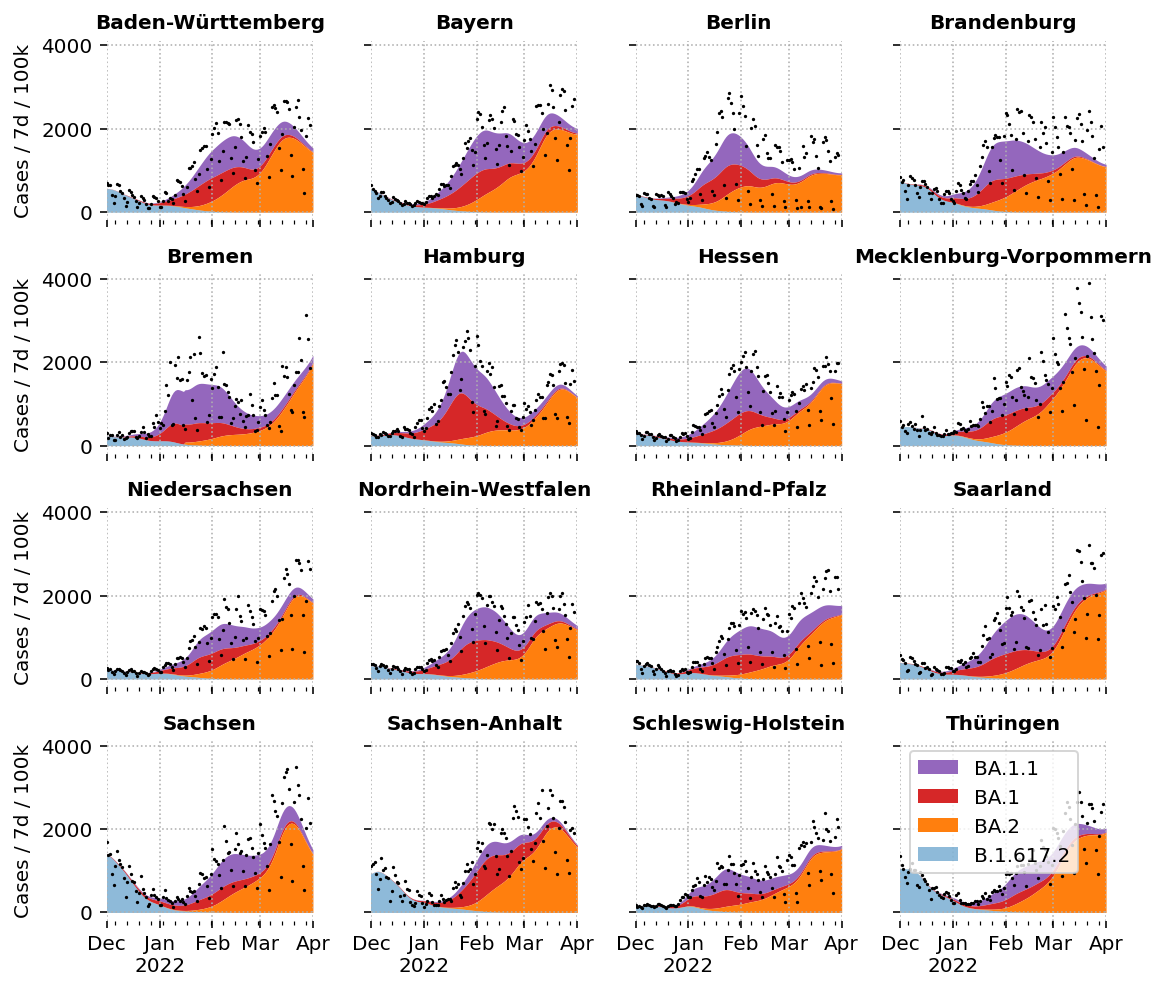

In [52]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(cases_land.index):
    y = pd.DataFrame(λ[i,:,:], columns=genomes.columns, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y[["B.1.617.2","BA.2","BA.1","BA.1.1","BA.3"]].cumsum(1) * 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    (cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    ax[i].fill_between(y.index, y["BA.1"], y["BA.1.1"], color='C4', alpha=1, lw=0, label="BA.1.1")
    ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [53]:
λ[-1,-1] / λ[-1,-1].sum()

array([9.93699712e-03, 5.59634207e-02, 9.34092230e-01, 7.02520478e-06,
       2.62920472e-07, 6.44243314e-08])

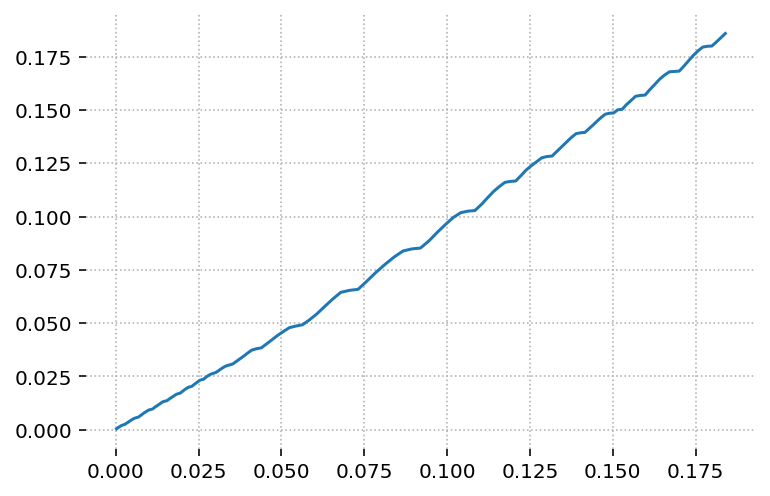

In [54]:
plt.plot(λ[2].sum(1).cumsum()[:-1], cases_land.loc['Berlin'].cumsum() / capita[2])

In [82]:
from genomicsurveillance.misc import get_transmissibility

In [319]:
b = np.array(model.posterior['b1'])
b[b==0] = np.nan
b[...,-1]= 0
r = pd.DataFrame((b - b[...,[1]]).mean((0,2)), columns=[alias(x) for x in merged_lineages], index=cases_land.index.to_list() + ["Germany"])

In [320]:
r

B.1.1.529  BA.1    BA.1.1      BA.2  BA.2.12.1  \
Baden-Württemberg        0.046984   0.0  0.024461  0.089179   0.033708   
Bayern                   0.030368   0.0  0.020977  0.086086   0.090696   
Berlin                   0.014089   0.0  0.022179  0.079479        NaN   
Brandenburg             -0.117351   0.0  0.024363  0.092914        NaN   
Bremen                  -0.110559   0.0  0.015885  0.075250        NaN   
Hamburg                  0.059688   0.0  0.028175  0.103041        NaN   
Hessen                  -0.135520   0.0  0.022955  0.099615   0.107662   
Mecklenburg-Vorpommern   0.025061   0.0  0.024161  0.087621        NaN   
Niedersachsen           -0.108379   0.0  0.027134  0.096345        NaN   
Nordrhein-Westfalen      0.047828   0.0  0.022698  0.095117   0.053225   
Rheinland-Pfalz         -0.117225   0.0  0.037718  0.113579        NaN   
Saarland                 0.045868   0.0  0.025320  0.096509        NaN   
Sachsen                  0.049930   0.0  0.027561  0.092181        NaN   
Sachsen-Anhalt           0.016698   0.0  0.027249  0.098743        NaN   
Schleswig-Holstein      -0.094041   0.0  0.024415  0.090176   0.139278   
Thüringen               -0.125447   0.0  0.021866  0.102504        NaN   
Germany                  0.057049   0.0  0.023263  0.088847   0.125689   

                            BA.4      BA.5     Other  B.1.617.2  
Baden-Württemberg      -0.173003  0.098385  0.057038  -0.141740  
Bayern                 -0.038308  0.138892  0.022210  -0.144317  
Berlin                       NaN  0.130613  0.036832  -0.134310  
Brandenburg                  NaN       NaN  0.075661  -0.122505  
Bremen                       NaN       NaN  0.036981  -0.144295  
Hamburg                      NaN  0.131600  0.072275  -0.125981  
Hessen                       NaN  0.101915  0.030798  -0.139461  
Mecklenburg-Vorpommern       NaN       NaN  0.047069  -0.144067  
Niedersachsen                NaN  0.115087  0.069797  -0.129047  
Nordrhein-Westfalen    -0.065503  0.121586  0.039449  -0.140449  
Rheinland-Pfalz              NaN       NaN  0.027632  -0.126954  
Saarland                     NaN       NaN  0.056052  -0.142435  
Sachsen                      NaN  0.146381  0.059718  -0.137971  
Sachsen-Anhalt               NaN       NaN  0.007795  -0.141901  
Schleswig-Holstein           NaN  0.100248  0.083086  -0.116022  
Thüringen                    NaN  0.061647  0.037441  -0.137968  
Germany                -0.177162  0.154165  0.047393  -0.129064

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(1, 0, 'B.1.1.529'),
  Text(2, 0, 'BA.1'),
  Text(3, 0, 'BA.1.1'),
  Text(4, 0, 'BA.2'),
  Text(5, 0, 'BA.2.12.1'),
  Text(6, 0, 'BA.4'),
  Text(7, 0, 'BA.5'),
  Text(8, 0, 'Other'),
  Text(9, 0, 'B.1.617.2')])

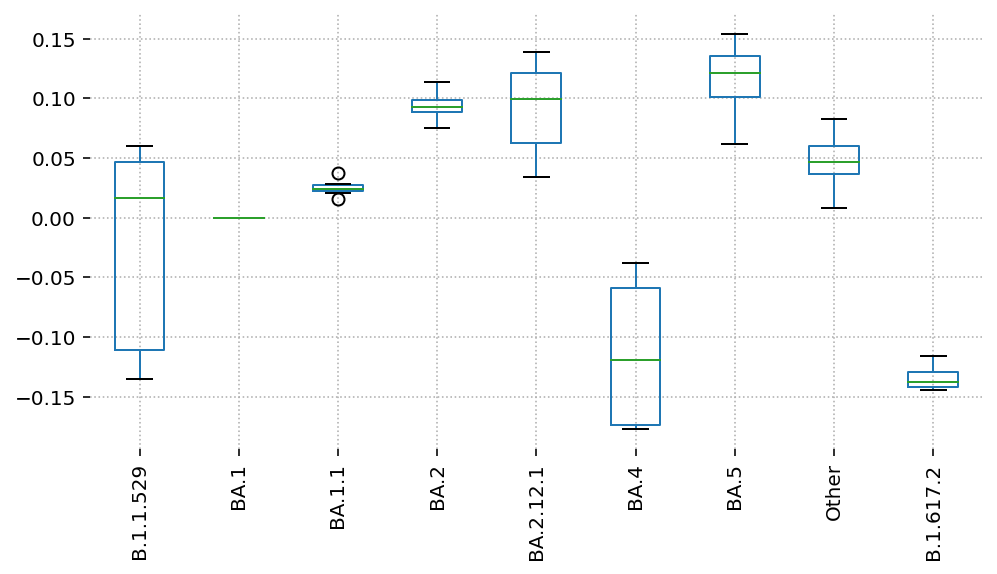

In [321]:
#r[r==0] = np.nan
plt.figure(figsize=(8,4))
r.boxplot(figsize=(8,4))
plt.xticks(rotation=90)
#r.mean(0).plot(ls="", marker=".")


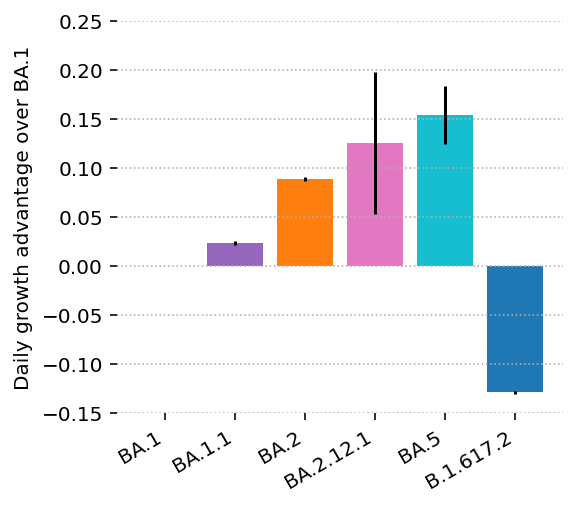

In [355]:
s = pd.DataFrame((b - b[...,[1]]).mean((2))[:,-1], columns=[alias(x) for x in merged_lineages]).iloc[:,[1,2,3,4,6,8]]
#s.boxplot()
plt.figure(figsize=(4,4))
plt.bar(s.columns, s.mean(), yerr=2*s.std(), color=['C3',"C4","C1", "C6" ,"C9", "C0"])
plt.ylim((-0.15,0.25))
#plt.draw()
#lt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.ylabel("Daily growth advantage over BA.1")
plt.grid(False)
plt.grid(axis="y")

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
B.1.1.529     974                   0.093908  0.072938   
BA.1       107462                   0.027026  0.007769   
BA.1.1     195312                   0.022135  0.006013   
BA.2       303958                   0.056339  0.010441   
BA.2.12.1      12                  -0.040980  0.050290   
BA.4            8                  -0.033160  0.051499   
BA.5           90                   0.126382  0.024396   
Other        3204                   0.123818  0.032719   
B.1.617.2  238596                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
B.1.1.529                       -0.037938  0.072938  
BA.1                             0.000000  0.006172  
BA.1.1                           0.035643  0.006002  
BA.2                             0.093549  0.009352  
BA.2.12.1                        0.031738  0.050286  
BA.4                            -0.093600  0.051623  
BA.5                             0.080544  0.023910  
Other                            0.014091  0.032719  
B.1.617.2                       -0.152073  0.000000

/Users/mg14/Git/desh-data/genomicsurveillance/misc/misc.py:917: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


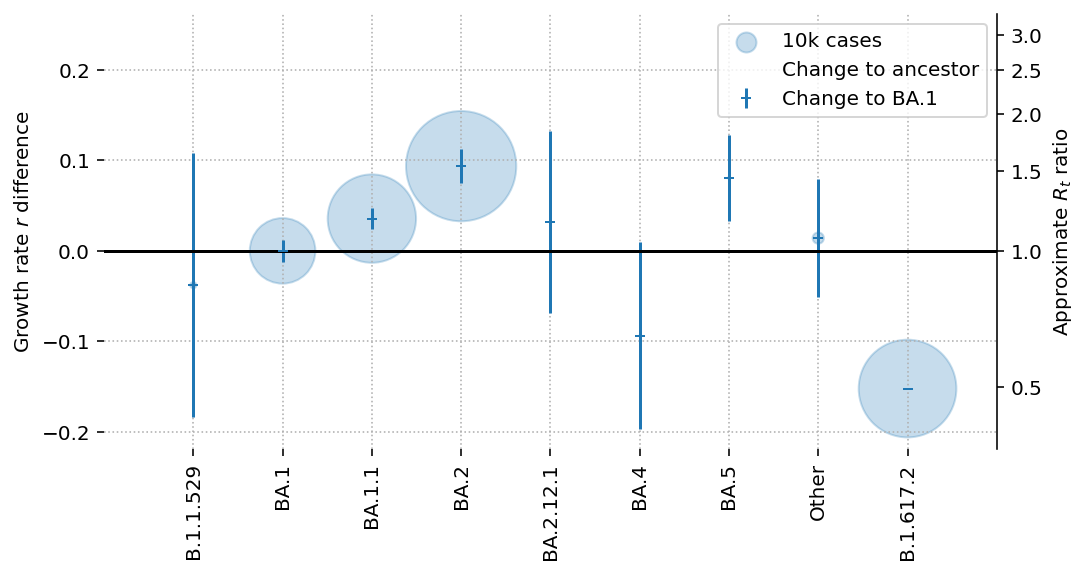

In [148]:
plt.figure(figsize=(8,4))
plot_growth_rates(model, [alias(x) for x in merged_lineages], color=["C0","None"], baseline="BA.1")

In [360]:
import geopandas as gpd

In [381]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [382]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [383]:
λ.sum(0)[-1] / λ.sum((0,2))[-1]

array([2.15288522e-04, 4.90127999e-04, 7.29437608e-03, 9.88248995e-01,
       6.20893242e-04, 1.97671796e-17, 1.93590697e-03, 1.19441189e-03,
       9.26731679e-11])

In [384]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [405]:
vmax

0.0010552848501374573

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


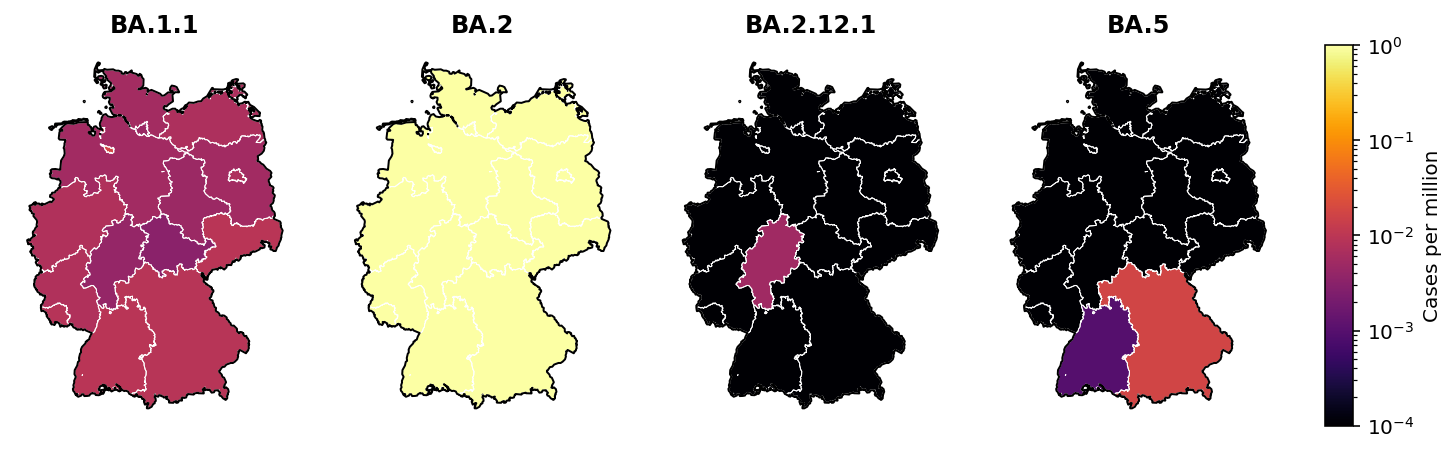

In [436]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = 1#1-1e-2 #λ[:-1,-1,:].max()
vmin = 1e-4
p = model.get_probabilities()
b0 = bl.copy().merge(pd.DataFrame(λ[:-1,-1,:]/λ[:-1,-1,:].sum(1, keepdims=True) + 1e-4, columns=[alias(x) for x in merged_lineages], index=bl.index), 
                     left_index=True, right_index=True)
for i, g in enumerate(["BA.1.1","BA.2","BA.2.12.1","BA.5"]):
    b0.plot(g, ax=axs[i], cmap="inferno",#["Purples","Oranges","GnBu","RdPu"][i], 
            norm=LogNorm(vmin=vmin, vmax=vmax), 
            cax=axs[4],
            legend_kwds={'label': "Cases per million", 'pad':0.3}, 
            legend=i==0, 
            missing_kwds= dict(color = "lightgrey"))
#b0.plot("BA.1.1", ax=axs[1], cmap="Purples", norm=LogNorm(vmin=vmin, vmax=vmax))
#b0.plot("BA.2", ax=axs[2], cmap="Oranges",norm=LogNorm(vmin=vmin, vmax=vmax))
#b0.plot("Other", ax=axs[3], cmap="Blues",norm=LogNorm(vmin=vmin, vmax=vmax))
    axs[i].set_title(g, weight='bold')
for ax in axs[:-1]:
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [386]:
b0.iloc[:,2:] * capita.values.reshape(-1,1)

B.1.1.529      BA.1     BA.1.1          BA.2  \
bundesland                                                                
Baden-Württemberg       1.883543e+00  3.079631  52.642528   5634.712014   
Bayern                  9.239523e-01  7.011032  82.398169   8932.680753   
Berlin                  7.129156e-02  1.230208  15.494119   2098.838582   
Brandenburg             1.045944e-11  0.393579   7.313904   1355.588718   
Bremen                  1.695011e-12  0.718811   8.141248    440.112645   
Hamburg                 5.999631e-01  0.583647   9.072471   1954.758359   
Hessen                  5.292444e-14  1.638437  26.702307   6618.295355   
Mecklenburg-Vorpommern  8.967187e-02  0.376390   4.663220    664.720074   
Niedersachsen           3.970144e-07  1.786235  33.371726   6030.588211   
Nordrhein-Westfalen     4.840199e+00  7.301521  90.099141  11858.489882   
Rheinland-Pfalz         2.424459e-12  0.683199  27.570891   3611.656835   
Saarland                3.474684e-01  0.559327   9.063536   1038.390795   
Sachsen                 8.853864e-01  0.698149  15.200453   1586.023408   
Sachsen-Anhalt          8.796976e-03  0.275390   5.612932   1184.911661   
Schleswig-Holstein      1.297336e-12  1.193746  16.357342   2855.009578   
Thüringen               6.466811e-09  0.168431   2.454498    779.794371   

                           BA.2.12.1          BA.4          BA.5     Other  \
bundesland                                                                   
Baden-Württemberg       3.105715e-11  7.678868e-14  5.064922e+00  4.380167   
Bayern                  2.519557e-09  1.716826e-12  1.611692e+02  1.700485   
Berlin                  0.000000e+00  0.000000e+00  5.528965e-09  0.818255   
Brandenburg             0.000000e+00  0.000000e+00  0.000000e+00  1.760799   
Bremen                  0.000000e+00  0.000000e+00  0.000000e+00  1.139284   
Hamburg                 0.000000e+00  0.000000e+00  4.329695e-09  5.784102   
Hessen                  3.540015e+01  0.000000e+00  1.415664e-09  0.208422   
Mecklenburg-Vorpommern  0.000000e+00  0.000000e+00  0.000000e+00  0.227734   
Niedersachsen           0.000000e+00  0.000000e+00  1.259503e-07  9.591274   
Nordrhein-Westfalen     8.869462e-09  1.560993e-12  5.445674e-09  7.262824   
Rheinland-Pfalz         0.000000e+00  0.000000e+00  0.000000e+00  0.032172   
Saarland                0.000000e+00  0.000000e+00  0.000000e+00  1.823491   
Sachsen                 0.000000e+00  0.000000e+00  7.374251e-10  3.693537   
Sachsen-Anhalt          0.000000e+00  0.000000e+00  0.000000e+00  0.002043   
Schleswig-Holstein      1.139780e-09  0.000000e+00  5.317432e-08  6.993398   
Thüringen               0.000000e+00  0.000000e+00  6.953959e-09  0.239284   

                           B.1.617.2  
bundesland                            
Baden-Württemberg       4.010882e-07  
Bayern                  3.028661e-07  
Berlin                  1.005914e-07  
Brandenburg             3.421493e-07  
Bremen                  1.202942e-08  
Hamburg                 7.259104e-08  
Hessen                  7.024828e-08  
Mecklenburg-Vorpommern  4.142959e-08  
Niedersachsen           7.021541e-07  
Nordrhein-Westfalen     4.510040e-07  
Rheinland-Pfalz         3.389480e-07  
Saarland                2.721392e-08  
Sachsen                 8.016983e-08  
Sachsen-Anhalt          7.507915e-08  
Schleswig-Holstein      8.749001e-07  
Thüringen               8.240026e-08

In [65]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-5,:]
r

array([[-1.17073431e-01, -8.72409463e-02, -2.49905770e-02,
        -3.33996603e-01, -2.40221833e-01, -2.56206262e-01],
       [-9.53045288e-02, -7.66980709e-02, -1.01037425e-02,
        -4.51850657e-01, -1.81135403e-01, -2.40760578e-01],
       [-8.50041977e-02, -6.02728009e-02, -4.07334947e-03,
        -2.27750612e-01, -2.02436696e-01, -2.27750612e-01],
       [-1.11172666e-01, -8.15255004e-02, -1.39356918e-02,
        -3.03596317e-01, -2.44137866e-01, -2.44137866e-01],
       [-5.44851079e-02, -3.83661998e-02,  3.11813242e-02,
        -1.96419871e-01, -1.40428822e-01, -1.96419871e-01],
       [-1.44524835e-01, -1.17987621e-01, -3.75336103e-02,
        -3.45094824e-01, -2.08678367e-01, -2.68897737e-01],
       [-1.17924524e-01, -9.33053921e-02, -1.65491929e-02,
        -3.16804863e-01, -2.15071610e-01, -2.47860992e-01],
       [-1.08861593e-01, -8.06443087e-02, -2.28301704e-02,
        -2.49512284e-01, -2.49512284e-01, -2.49512284e-01],
       [-1.23489015e-01, -9.37075788e-02, -2.636

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


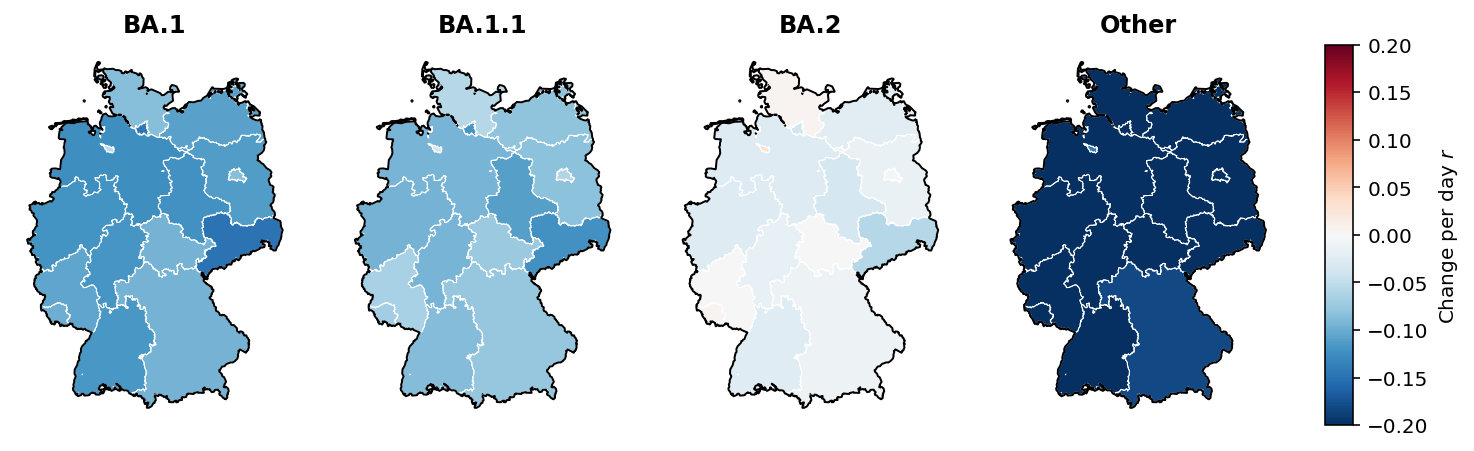

In [66]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
d = pd.DataFrame(r[:-1,:], columns=genomes.columns, index=bl.index)
#d.loc["Sachsen-Anhalt"]=np.nan
b0 = bl.copy().merge(d, 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="RdBu_r", vmin=-0.2,vmax=0.2, cax=axs[4], legend_kwds={'label': "Change per day $r$", 'pad':0.3}, legend=True, missing_kwds= dict(color = "lightgrey"))# norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#, norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
for i,ax in enumerate(axs[:-1]):
    ax.set_title(genomes.columns[[0,1,2,4]][i], weight='bold')
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [67]:
from sklearn.linear_model import LinearRegression as LR
from adjustText import adjust_text
import re

In [68]:
j

24

0.07069868281110661
0.08626862616509487
0.04385605918808592
0.042607422277869476


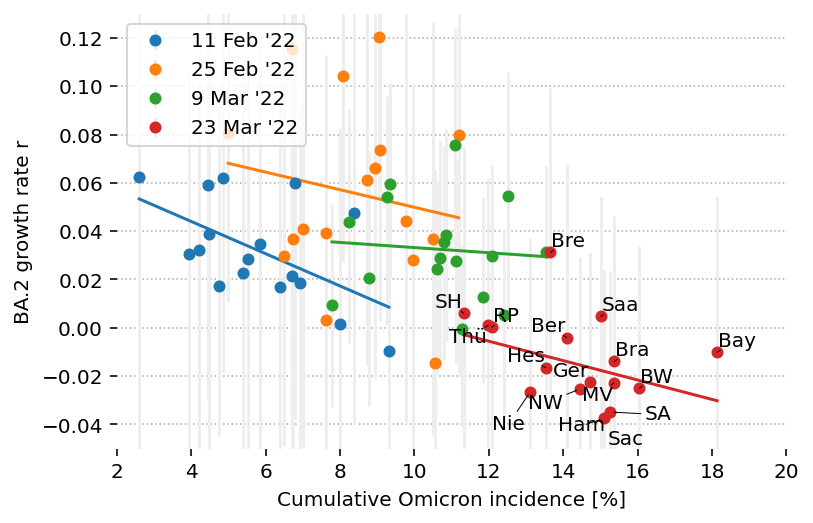

In [80]:
fig, axs = plt.subplots(1,1, figsize=(6,4), sharey=True)
#axs = axs.flatten()
text=[]
for k,l in enumerate(["2022-02-11", "2022-02-25","2022-03-09","2022-03-23"]):
    j = np.where(cases_land.columns == l)[0][0]
    ax = axs#[0]
    ci = np.quantile(model.get_growth_rate_lineage(ltla=None)[:,:,j,2], (0.1, 0.9), axis=0)
    r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,j,:]

    lr = LR()
    x = λ[...,:j,:3].sum((1,2)) * 100
    y = r[:,2]
    lr.fit(x[:,np.newaxis], y)
    ax.errorbar(x, y, yerr=np.abs(ci - y[np.newaxis,:]), ls="", marker=".", ms=10,color=f'C{k}', ecolor='#EEEEEE', 
               label=cases_land.columns[j].strftime("%-d %b \'%y"))
    #ax.set_title(cases_land.columns[j].strftime("%-d %b \'%y"))

    l=[re.sub("[a-zöüä\-]","",x) if re.search("-",x) else x[:3] for x in (cases_land.index.to_list() + ['Germany'])]
    
    for i in range(x.shape[0]):
        if k==3:#l[i]#in ["BW","NW","RP","Saa"]:
            text.append(ax.text(x[i], y[i], l[i], color='k', va='bottom', ha='center'))
    x.sort()
    y = lr.predict(x[:,np.newaxis])
    line = ax.plot(x, y, ls="-", c=f'C{k}')
    #plt.axline((0, lr.intercept_), slope=lr.coef_)
    #plt.scatter(λ[...,:2].sum((1,2)), r[:,2])
    ax.set_xlabel("Cumulative Omicron incidence [%]")
    if k == 0: 
        ax.set_ylabel("BA.2 growth rate r") 
    ax.set_ylim((-0.05,0.13))
    ax.set_xlim((2,20))
    print(lr.intercept_)

adjust_text(text, 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), )
ax.grid(axis='x', which='major')
ax.legend(loc='upper left')


In [70]:
λ[-1,-1,2]/ λ[-1,-1,:].sum()

0.9340922296138215

In [71]:
d = pd.DataFrame(model.get_growth_rate_lineage(ltla=None).mean(0)[:,[-24,-10],2], index=cases_land.index.to_list() + ["Germany"], columns=cases_land.columns[[-24,-10]])

<AxesSubplot:>

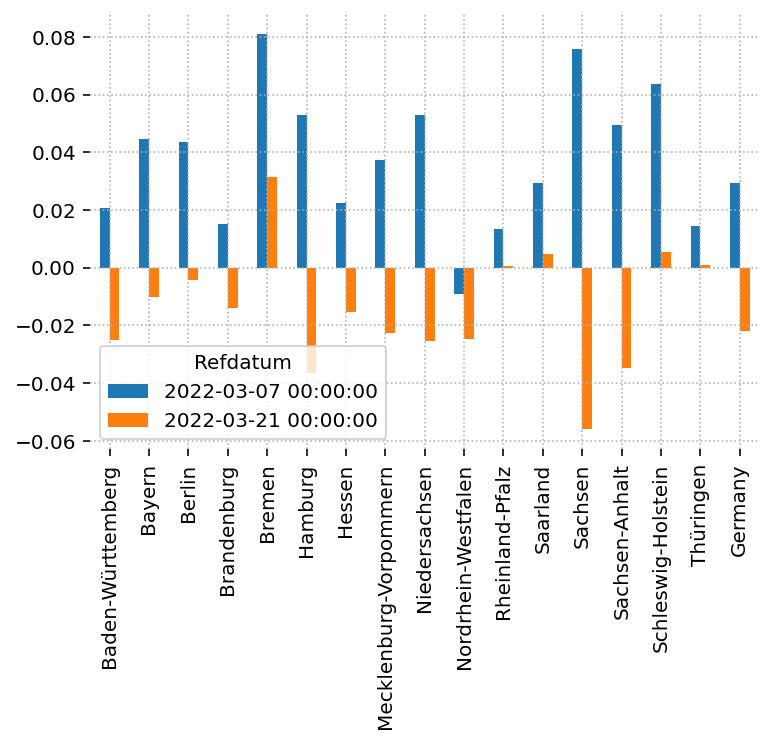

In [72]:
d.plot.bar()

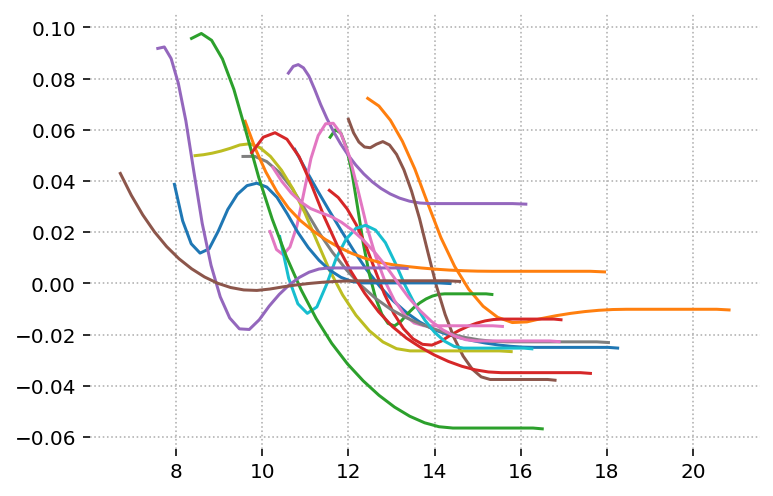

In [73]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-28:,2]
x = λ[...,:,:3].sum(2).cumsum(1)[:,-28:] * 100
for i in range(r.shape[0]):
    plt.plot(x[i,:],r[i,:])

(18962.0, 19077.0)

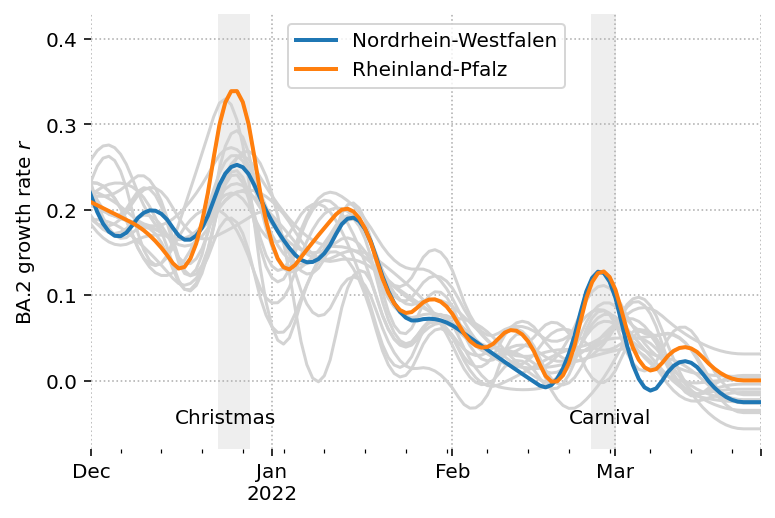

In [74]:
r = np.mean(model.get_growth_rate_lineage(ltla=None),0)[:,:,2]
r = pd.DataFrame(r.T[:-5], index=cases_land.columns[:-4].to_list(), columns=cases_land.index.to_list() + ["Germany"])
r.plot(c = 'lightgrey', alpha=1, legend=False)
r[["Nordrhein-Westfalen","Rheinland-Pfalz"]].plot( alpha=1, lw=2, ax=plt.gca())
#plt.legend("off")
plt.ylabel("BA.2 growth rate $r$")
plt.axvspan("2021-12-23","2021-12-28", color='#EEEEEE', zorder=0)
plt.axvspan("2022-02-25","2022-03-01", color='#EEEEEE', zorder=0)
plt.text("2021-12-24",-0.05,"Christmas", ha='center')
plt.text("2022-02-28",-0.05,"Carnival", ha='center')
plt.xlim(("2021-12-01",None))

In [64]:
from celluloid import Camera
from tqdm import tqdm
from matplotlib import colors


100%|██████████| 122/122 [00:42<00:00,  2.87it/s]


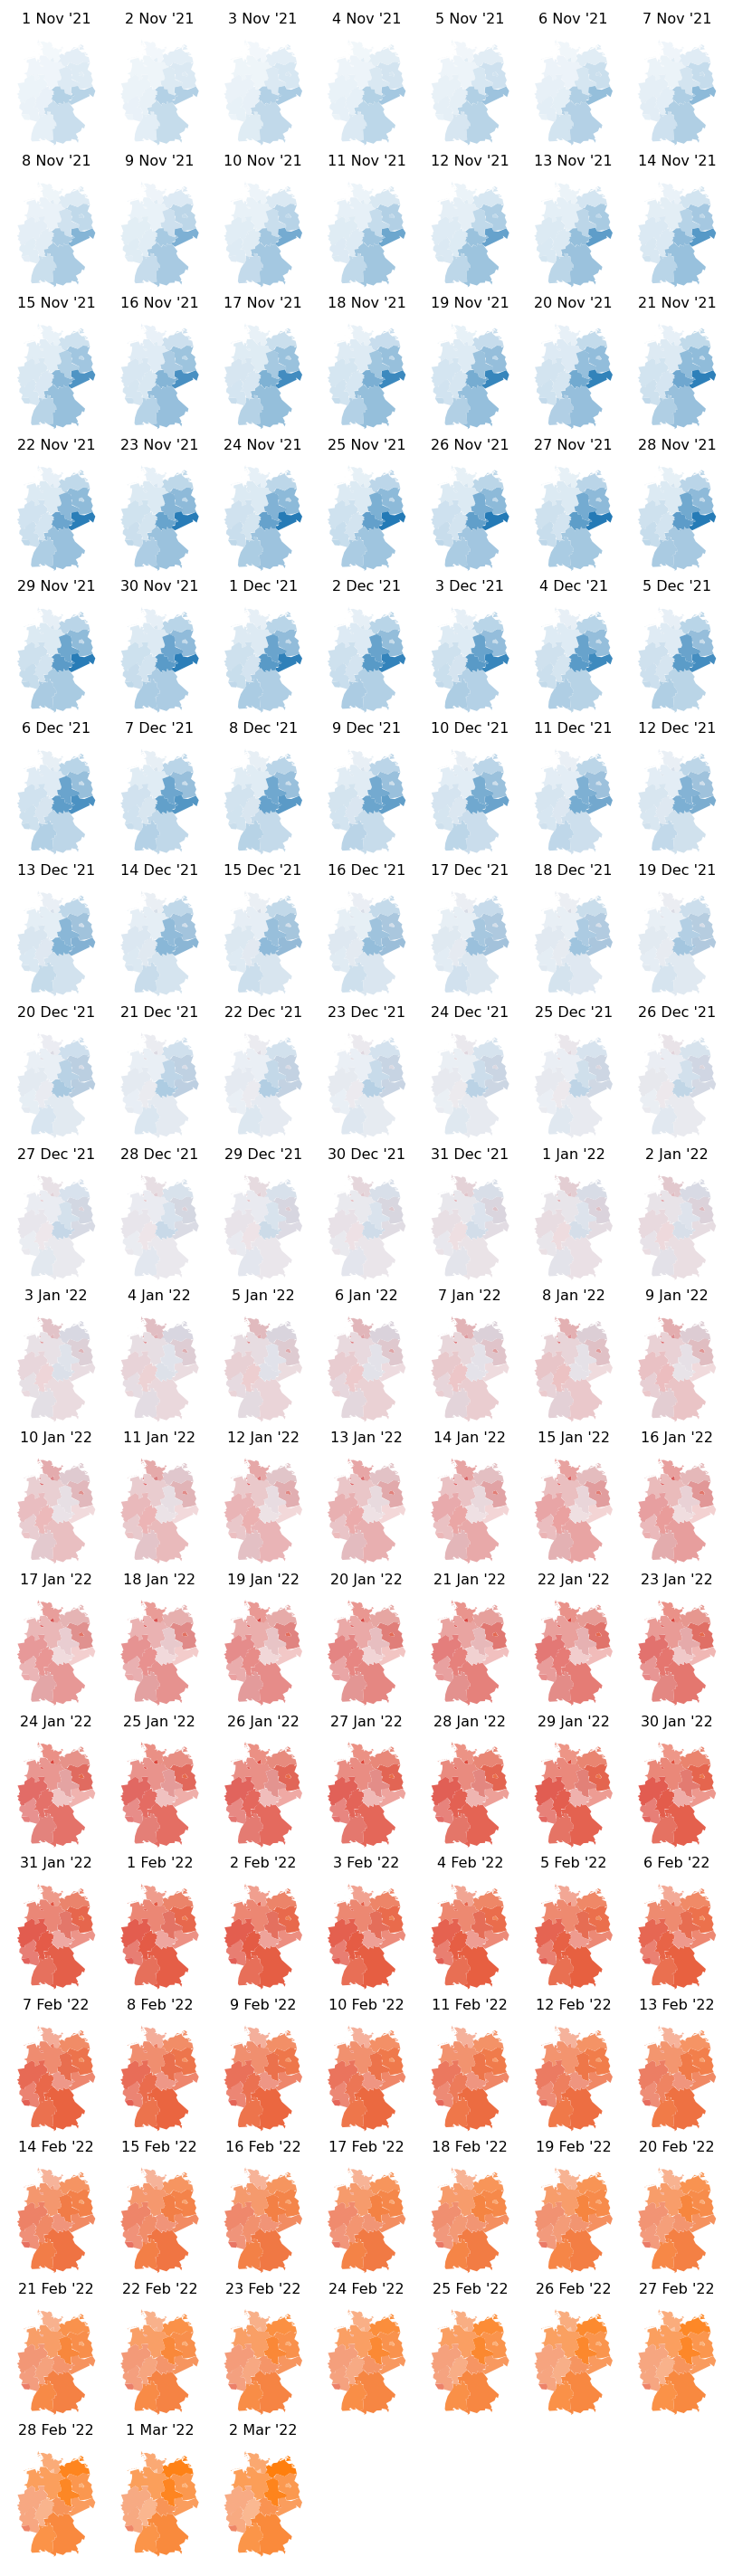

In [65]:
n = 7
m = (int(λ.shape[1]/7)+1)
fig, axs = plt.subplots(m,n, figsize=(7,10*m/n))
#camera = Camera(fig)
b0 = bl.copy().simplify(1e-1)
axs = axs.flatten()
for ax in axs:
    ax.axis("off")

    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def alpha_to_color(alpha, c):
    c0 = []#(1,1,1)
    for x in alpha:
        cc = (1,1,1)
        for j, y in enumerate(x):
            cc = make_rgb_transparent(c[j ], cc, y)
        c0 += [cc]
    return c0

cols = [colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C1"),
     colors.colorConverter.to_rgb("C0")]

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    ax = axs[i]
        
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()

    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)

    ax.set_title((cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=8)
    b0.plot(color=c, ax=ax)

    #bl.boundary.plot(color='w',lw=0.5, ax=ax)
    #de.boundary.plot(color='k',lw=1, ax=ax)
    #camera.snap()


In [66]:
f"{λ[:-1,-1,1] @ capita.values:0.0f}"

'37221'

In [67]:
λ.max()*700

1.4526477300739673

100%|██████████| 122/122 [07:36<00:00,  3.74s/it]


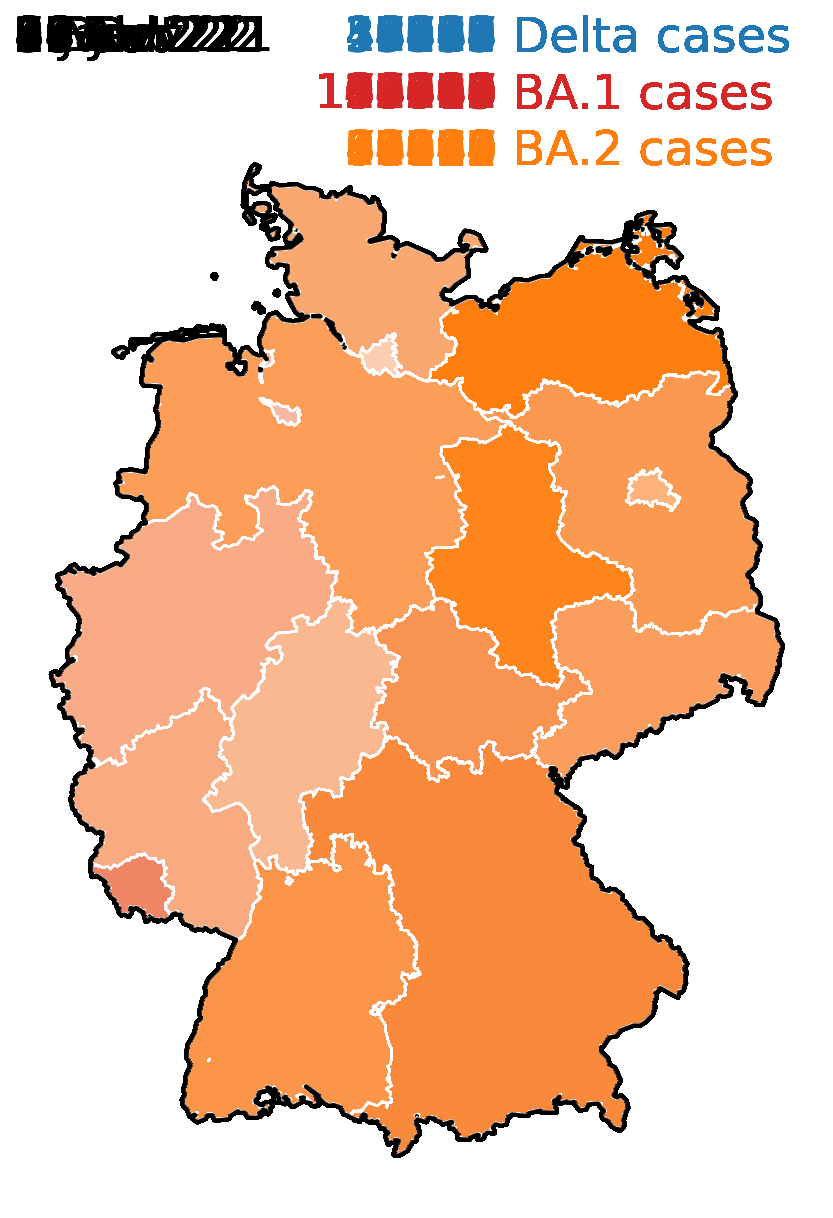

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,10.5), facecolor=None)
camera = Camera(fig)
b0 = bl.copy()#.simplify(1e-2)

ax.axis("off")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()
    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)
    #c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]
    b0.plot(color=c, ax=ax)

    #ax.set_title(cases_land.columns[i].strftime("%-d %b \'%y"), size=12)
    if i == 0:
        ax.set_ylim((None, ax.get_ylim()[0] + 1.05 * (ax.get_ylim()[1]-ax.get_ylim()[0])))
    
    ax.text(0.0, 1.01,  (cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=24, transform=ax.transAxes)
    ax.text(0.6, 1.01,  f"{λ[:-1,i,-1] @ capita.values:0.0f}", color = "C0", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 0.96,  f"{λ[:-1,i,[0,1]].sum(-1) @ capita.values:0.0f}", color = "C3", size=24, transform=ax.transAxes, ha= 'right')
    ax.text(0.6, 0.91,  f"{λ[:-1,i,2] @ capita.values:0.0f}", color = "C1", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 1.01,  f" Delta cases", color = "C0", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.96,  f" BA.1 cases", color = "C3", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.91,  f" BA.2 cases", color = "C1", size=24, transform=ax.transAxes)

    bl.boundary.plot(color='w',lw=1, ax=ax)
    de.boundary.plot(color='k',lw=2, ax=ax)
    camera.snap()


In [69]:
animation = camera.animate(interval = 100, blit=True, repeat = False, repeat_delay=1000)

In [70]:
#import ffmpeg
from IPython.display import HTML
import re
HTML(re.sub("width=\"576\"","width=288",animation.to_html5_video()))

# UK analysis

In [209]:
import requests
cases_uk = pd.read_csv("https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv", parse_dates=True, index_col=3)["newCasesBySpecimenDate"].sort_index().loc["2021-11-01":].iloc[:-1]

In [210]:
cases_uk

date
2021-11-01    45069
2021-11-02    37976
2021-11-03    35934
2021-11-04    33616
2021-11-05    30295
              ...  
2022-02-17    43559
2022-02-18    32333
2022-02-19    33861
2022-02-20    36757
2022-02-21    42078
Name: newCasesBySpecimenDate, Length: 113, dtype: int64

In [211]:
x = []
c = "United Kingdom"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])

genomes_uk = pd.DataFrame(x).T.fillna(0)#
genomes_uk = genomes_uk.loc[genomes_uk.index <= cases_uk.index.max(),:]
genomes_uk.sum(0)

BA.1          338473.0
BA.1.1        138324.0
BA.2           29613.0
BA.3              18.0
B.1.617.2*    372938.0
dtype: float64

In [212]:
genomes_uk = genomes_uk[genomes_uk.sum(1) > 100]

In [213]:
genomes_uk

BA.1  BA.1.1    BA.2  BA.3  B.1.617.2*
date                                                
2021-11-01     0.0     0.0     0.0   0.0      7781.0
2021-11-02     0.0     0.0     0.0   0.0      5999.0
2021-11-03     1.0     0.0     0.0   0.0      7031.0
2021-11-04     0.0     0.0     0.0   0.0      6415.0
2021-11-05     0.0     0.0     0.0   0.0      7034.0
...            ...     ...     ...   ...         ...
2022-02-12  1279.0  1889.0  1444.0   1.0         1.0
2022-02-13   635.0   983.0   856.0   0.0         1.0
2022-02-14   764.0  1270.0  1026.0   0.0         0.0
2022-02-15   368.0   617.0   593.0   0.0         1.0
2022-02-16    30.0    57.0    72.0   0.0         0.0

[108 rows x 5 columns]

In [214]:
genomes_uk["BA.1"][:"2021-11-18"] = 0
genomes_uk["BA.1.1"][:"2021-11-18"] = 0
genomes_uk["BA.2"][:"2021-12-18"] = 0

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,8,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]
#bar[1,genomes_uk.index > d[1],:] = 0
#bar[2,genomes_uk.index <= d[1],:] = 0

In [216]:
date_split

array(['2021-12-14', '2021-12-28', '2022-01-11', '2022-01-25'],
      dtype='datetime64[D]')

In [217]:
foo = np.stack((len(date_split)+1) * [cases_uk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_uk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_uk.index > dd,:] = 0
    bar[i+1,genomes_uk.index <= dd,:] = 0


In [218]:
model_uk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]),
    np.repeat(67.22e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=10.,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [219]:
model_uk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


KeyboardInterrupt: 

In [ ]:
plt.plot(model_uk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,4]#np.arange(genomes_uk.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_uk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_uk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right= 5 if j == 0 else 1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("United Kingdom", size=12, weight='bold')
#ax[0].set_yscale("log")

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.2,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
#f = ax[2].xaxis.get_major_formatter()
#ax[1].xaxis.set_major_formatter(f)
#ax[1].set_xticklabels(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(),visible=True)
#plt.delaxes(ax[3])
#plt.delaxes(ax[0])
#ax[1].xaxis.set_tick_params(labelbottom=True)

#ax[1].xaxis.set_major_formatter(f)


In [ ]:
## import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_uk, genomes_uk.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [ ]:
bar.shape

In [ ]:
ax=plt.gcf().get_axes()

In [ ]:
ax

## Germany

In [358]:
foo = np.stack((len(date_split)+1) * [CC[-1]], axis=0)
bar = np.stack((len(date_split)+1)  * [GG[-1]], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes.index.levels[1] > dd + np.timedelta64(2,"D"),:] = 0
    bar[i+1,genomes.index.levels[1] < dd - np.timedelta64(1,"D"),:] = 0
bar[0,:,2] = 0

In [359]:
model_de = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    seq_index,
    np.repeat(capita.values.sum().reshape(1),len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [360]:
model_de.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

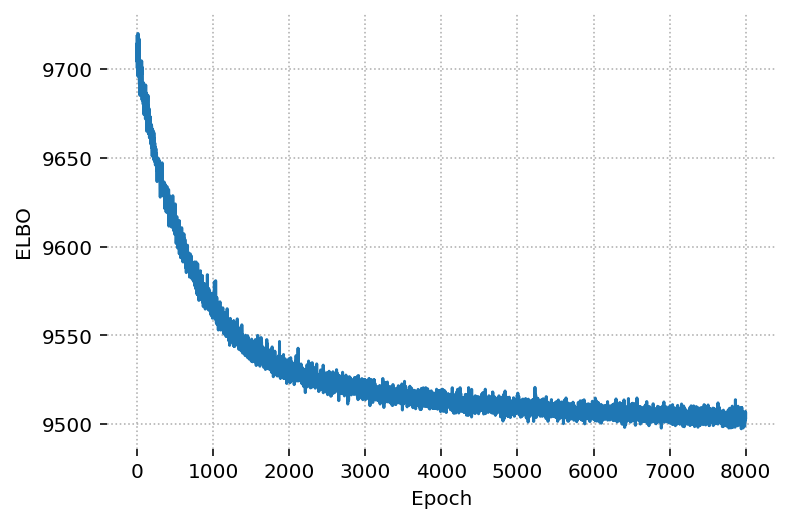

In [361]:
plt.plot(model_de.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [362]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

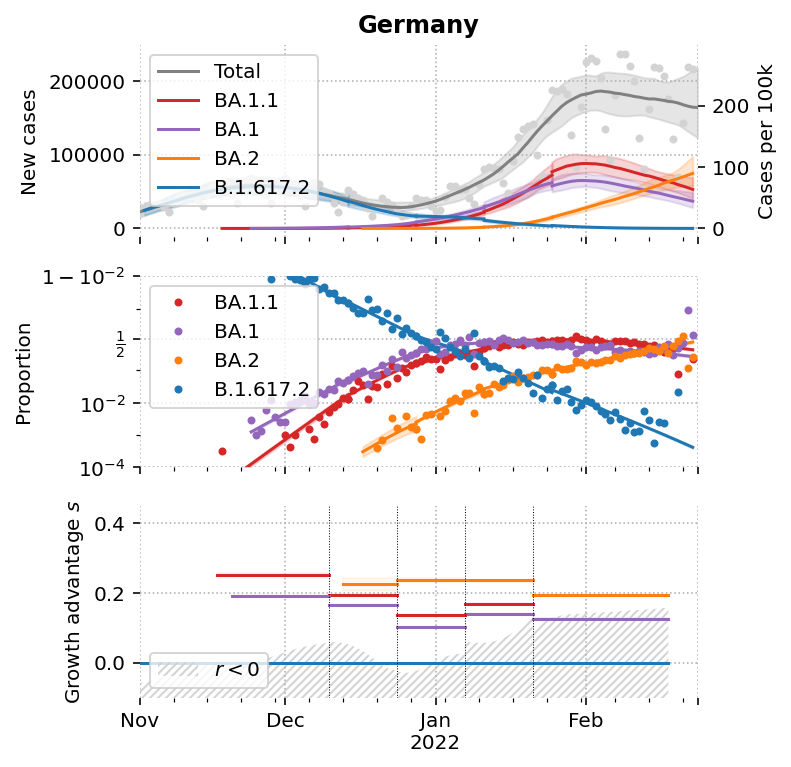

In [363]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [1,0,2,5]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_de, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C4','C3', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = -1,
             bleed_right= 5 if j == 0 else -1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Germany", size=12, weight='bold')

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])



In [364]:
pd.DataFrame(get_transmissibility(model_de), columns=genomes.columns)

lineage      BA.1    BA.1.1      BA.2      BA.3     Other  B.1.617.2
0        0.191420  0.252462  0.021681  0.042103  0.074427        0.0
1        0.165376  0.194052  0.223760  0.042103  0.086572        0.0
2        0.102504  0.135664  0.237153  0.133593  0.063556        0.0
3        0.140669  0.169088  0.236354 -0.056527 -0.127477        0.0
4        0.124018  0.126526  0.194083  0.188843  0.192795        0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1        64760                   0.018187  0.031125   
BA.1.1      62333                   0.018127  0.045396   
BA.2        14991                   0.021681  0.017539   
BA.3           25                   0.042103  0.110309   
Other         274                   0.031535  0.103882   
B.1.617.2  137593                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.031125  
BA.1.1                           0.030761  0.045396  
BA.2                             0.078040  0.017539  
BA.3                            -0.056161  0.110309  
Other                           -0.086823  0.103882  
B.1.617.2                       -0.144798  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:876: RuntimeWarning: divide by zero encountered in log
  ax3.set_ylabel("Approximate $R_t$ ratio")


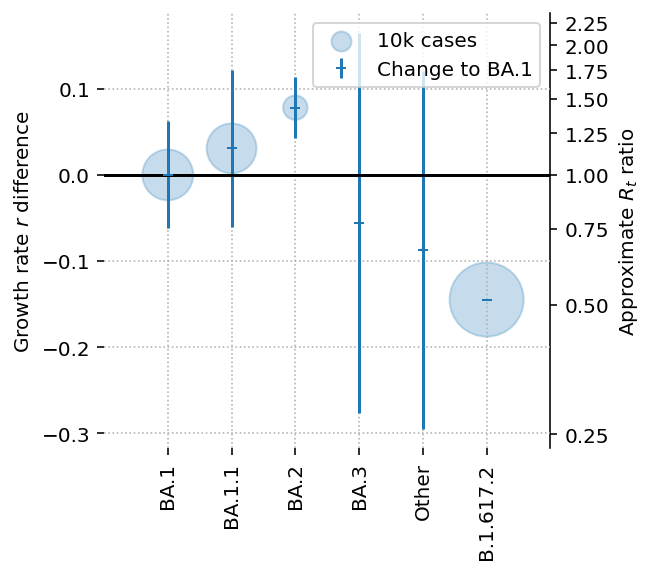

In [365]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_de, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")


## Denmark

In [ ]:
cases_dk = pd.read_csv("../overvaagningsdata-dashboard-covid19-31012022-40ip/Regionalt_DB/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", index_col=[0,1],parse_dates=True, encoding='latin_1', sep=";").sum(level=1).loc["2021-11-01":].iloc[:-1,0]

In [ ]:
cases_dk

In [ ]:
x = []
c = "Denmark"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    try:
        x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])
    except:
        pass


genomes_dk = pd.DataFrame(x).T.fillna(0)#
genomes_dk = genomes_dk.loc[genomes_dk.index <= cases_dk.index.max(),:]
genomes_dk.sum(0)

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,6,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]

In [ ]:
foo = np.stack((len(date_split)+1) * [cases_dk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_dk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_dk.index > dd,:] = 0
    bar[i+1,genomes_dk.index <= dd,:] = 0


In [ ]:
model_dk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_dk.index.to_list().index(i) for i in genomes_dk.index]),
    np.repeat(5.831e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.1,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':12000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [ ]:
foo.shape

In [ ]:
model_dk.fit()

In [ ]:
plt.plot(model_dk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,3]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_dk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_dk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C0", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right=3 if j ==0 else 1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Denmark", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend().remove()
ax[1].legend(facecolor='white')
ax[2].legend(loc='lower right')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])


In [ ]:
(bar[-1,-15:] )

In [ ]:
genomes_dk

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_dk, genomes_dk.columns.to_list(), color=["C0","None"], baseline="BA.1")
